In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)

import seaborn as sns
from datetime import datetime, timedelta

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm


from scipy import stats
import statsmodels.api as sm
from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [169]:
btc = pd.read_csv("C:/Users/Anil/Desktop/cryptoDataCollection (2)/top 5/XRP-USD.csv")

In [170]:
btc

Date      High       Low      Open     Close      Volume  \
0     2017-11-09  0.221791  0.214866  0.217911  0.217488   147916992   
1     2017-11-10  0.219068  0.205260  0.218256  0.206483   141032992   
2     2017-11-11  0.214456  0.205459  0.205948  0.210430   134503008   
3     2017-11-12  0.210214  0.195389  0.210214  0.197339   251175008   
4     2017-11-13  0.204081  0.197456  0.197472  0.203442   132567000   
...          ...       ...       ...       ...       ...         ...   
1563  2022-02-19  0.849816  0.773650  0.785865  0.822528  3325442943   
1564  2022-02-20  0.822672  0.769985  0.822538  0.778296  3041836889   
1565  2022-02-21  0.799750  0.701989  0.778160  0.703466  3580522306   
1566  2022-02-22  0.725191  0.678787  0.703333  0.722833  3539593096   
1567  2022-02-23  0.737283  0.708174  0.721408  0.737283  3005903616   

      Adj Close  
0      0.217488  
1      0.206483  
2      0.210430  
3      0.197339  
4      0.203442  
...         ...  
1563   0.822528  
1564   0.778296  
1565   0.703466  
1566   0.722833  
1567   0.737283  

[1568 rows x 7 columns]

In [171]:
btc['Date'] = pd.to_datetime(btc['Date'], format='%Y-%m-%d')

In [172]:
btc['Close'].describe()

count    1568.000000
mean        0.534386
std         0.391527
min         0.139635
25%         0.265114
50%         0.377526
75%         0.699002
max         3.377810
Name: Close, dtype: float64

In [173]:
btc = btc.set_index('Date')

In [174]:
# Resampling to monthly frequency
btc_month = btc.resample('M').mean()

Dickey–Fuller test: p=0.067031


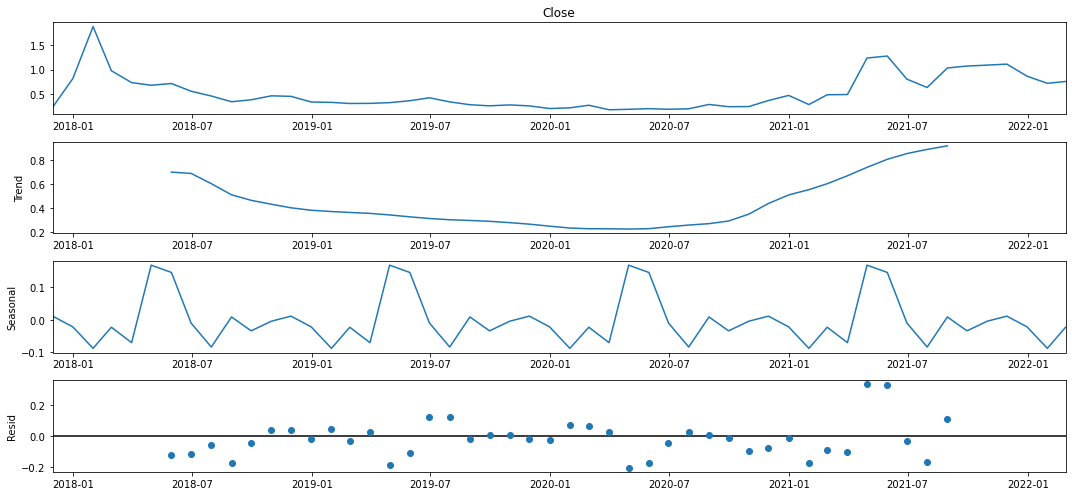

In [175]:
#seasonal_decompose(btc_month.close, freq=12).plot()
seasonal_decompose(btc_month.Close).plot()
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.Close)[1])
plt.show()

In [176]:
# Box-Cox Transformations
btc_month['close_box'], lmbda = stats.boxcox(btc_month.Close)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.close_box)[1])

Dickey–Fuller test: p=0.264865


In [177]:
# Seasonal differentiation (12 months)
btc_month['box_diff_seasonal_12'] = btc_month.close_box - btc_month.close_box.shift(12)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_12[12:])[1])

Dickey–Fuller test: p=0.486017


In [178]:
# Seasonal differentiation (3 months)
btc_month['box_diff_seasonal_3'] = btc_month.close_box - btc_month.close_box.shift(3)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_3[3:])[1])

Dickey–Fuller test: p=0.169174


Dickey–Fuller test: p=0.000000


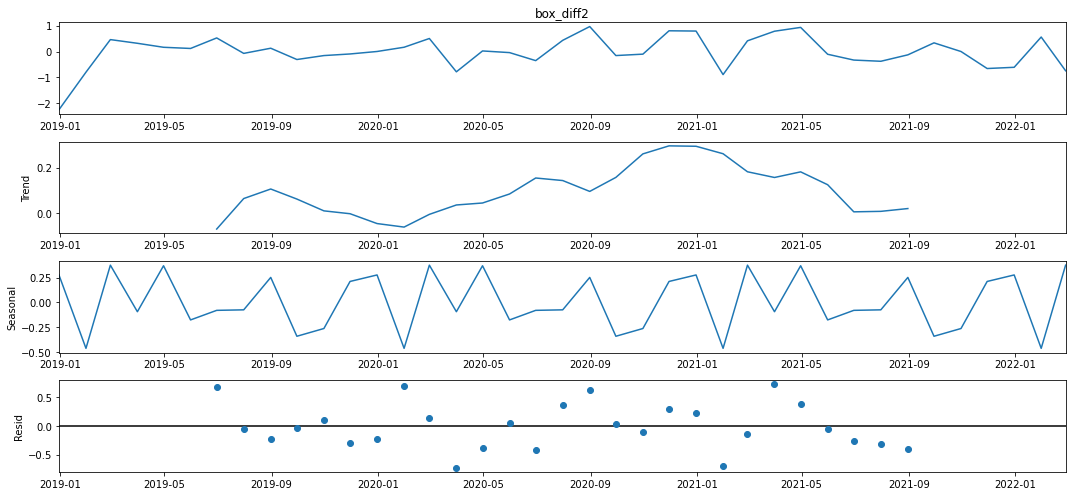

In [179]:
# Regular differentiation
btc_month['box_diff2'] = btc_month.box_diff_seasonal_12 - btc_month.box_diff_seasonal_12.shift(1)

# STL-decomposition
seasonal_decompose(btc_month.box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff2[13:])[1])

plt.show()

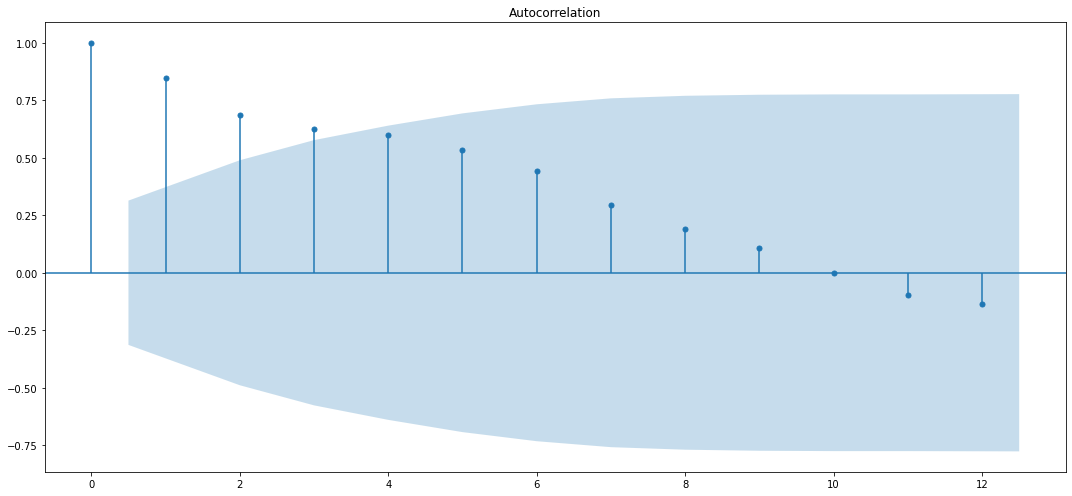

In [180]:
#autocorrelation_plot(btc_month.close)
plot_acf(btc_month.Close[13:].values.squeeze(), lags=12)

plt.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'google'

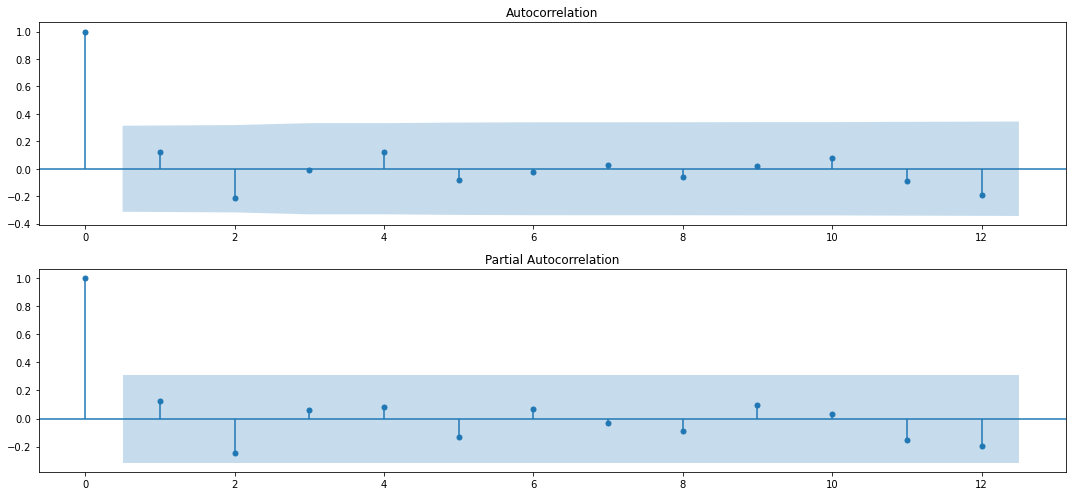

In [181]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
ax = plt.subplot(211)
# Plot the autocorrelation function
#sm.graphics.tsa.plot_acf(btc_month.box_diff2[13:].values.squeeze(), lags=48, ax=ax)

plot_acf(btc_month.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
ax = plt.subplot(212)
#sm.graphics.tsa.plot_pacf(btc_month.box_diff2[13:].values.squeeze(), lags=48, ax=ax)

plot_pacf(btc_month.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
plt.tight_layout()
from google.colab import files
plt.savefig("USDC-Partial Autocorrelation.png")
files.download("USDC-Partial Autocorrelation.png")
plt.show()

In [182]:
# Initial approximation of parameters
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
AIC = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [183]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  parameters        aic
0     (0, 0)  65.527071
6     (2, 0)  65.648313
2     (0, 2)  66.833159
1     (0, 1)  67.314145
3     (1, 0)  67.435791


In [184]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   52
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -31.764
Date:                Wed, 25 May 2022   AIC                             65.527
Time:                        17:23:12   BIC                             67.459
Sample:                    11-30-2017   HQIC                            66.265
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.2035      0.024      8.579      0.000       0.157       0.250
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                40.08
Prob(Q):                              0.79   Pr

In [61]:
AIC.append(best_model.aic)

In [20]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

Dickey–Fuller test:: p=0.000000


In [ ]:
BIC

[]

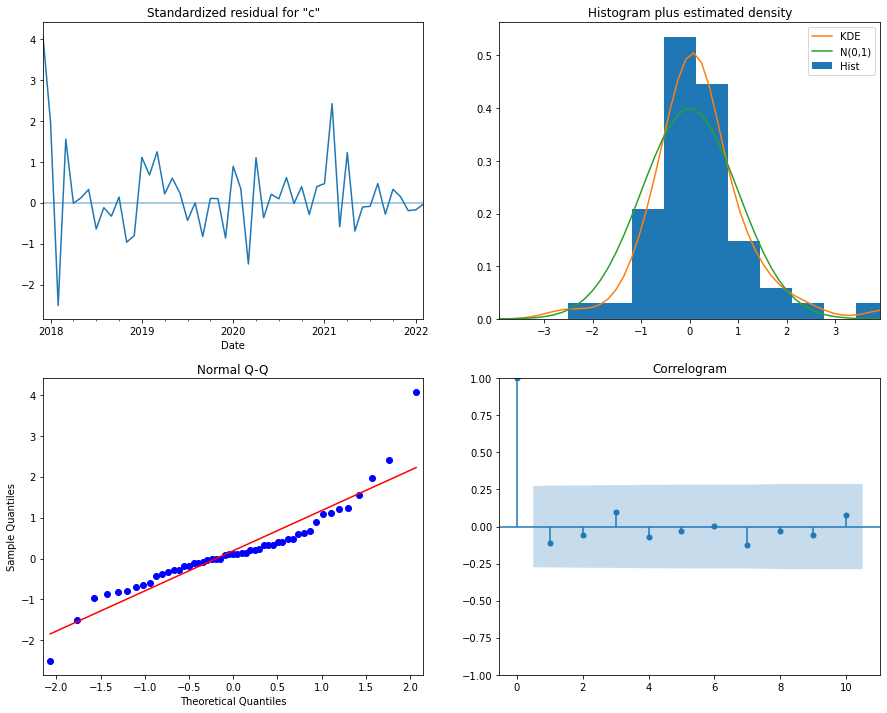

In [40]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [185]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

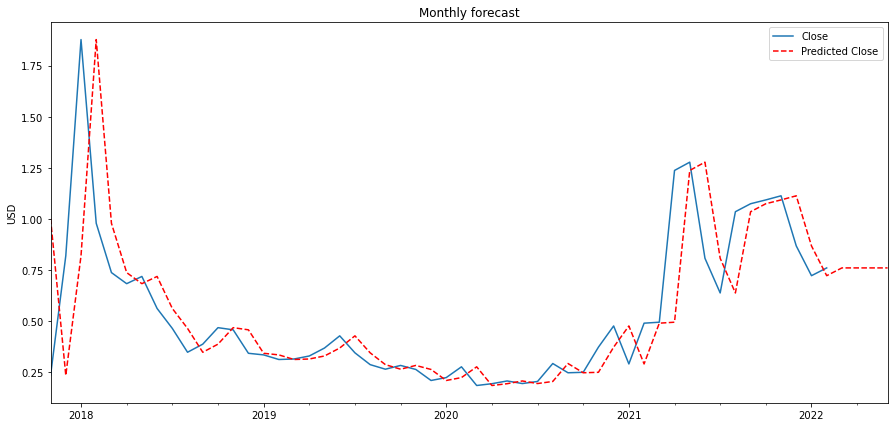

In [186]:
# Prediction
btc_month_pred = btc_month[['Close']]
#date_list = [datetime(2018, 3, 31), datetime(2018, 4, 30), datetime(2018, 5, 31), datetime(2018, 6, 30), 
#             datetime(2018, 7, 31), datetime(2018, 8, 31), datetime(2018, 9, 30), datetime(2018, 10, 31),
#             datetime(2018, 11, 30), datetime(2018, 12, 31)]
date_list = [datetime(2022, 3, 31), datetime(2022, 4, 30), datetime(2022, 5, 31), datetime(2022, 6, 30)]
future = pd.DataFrame(index=date_list, columns= btc_month.columns)
btc_month_pred = pd.concat([btc_month_pred, future])

btc_month_pred['forecast'] = invboxcox(best_model.predict(start=0, end=120), lmbda)


plt.figure(figsize=(15,7))
btc_month_pred.Close.plot()
btc_month_pred.forecast.plot(color='r', ls='--', label='Predicted Close')
plt.legend()
plt.title('Monthly forecast')
plt.ylabel('USD')
plt.show()

In [187]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results_sarima = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
#        model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
         model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 4)).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results_sarima.append([param, model.aic])

In [188]:
# Best Models
result_table = pd.DataFrame(results_sarima)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters        aic
37  (2, 0, 0, 1)  71.633615
39  (2, 0, 1, 1)  71.991669
15  (0, 2, 1, 1)  72.046340
13  (0, 2, 0, 1)  72.963700
3   (0, 0, 1, 1)  73.153757
                                      SARIMAX Results                                      
Dep. Variable:                           close_box   No. Observations:                   52
Model:             SARIMAX(2, 1, 0)x(0, 1, [1], 4)   Log Likelihood                 -31.817
Date:                             Wed, 25 May 2022   AIC                             71.634
Time:                                     17:23:34   BIC                             79.034
Sample:                                 11-30-2017   HQIC                            74.419
                                      - 02-28-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------

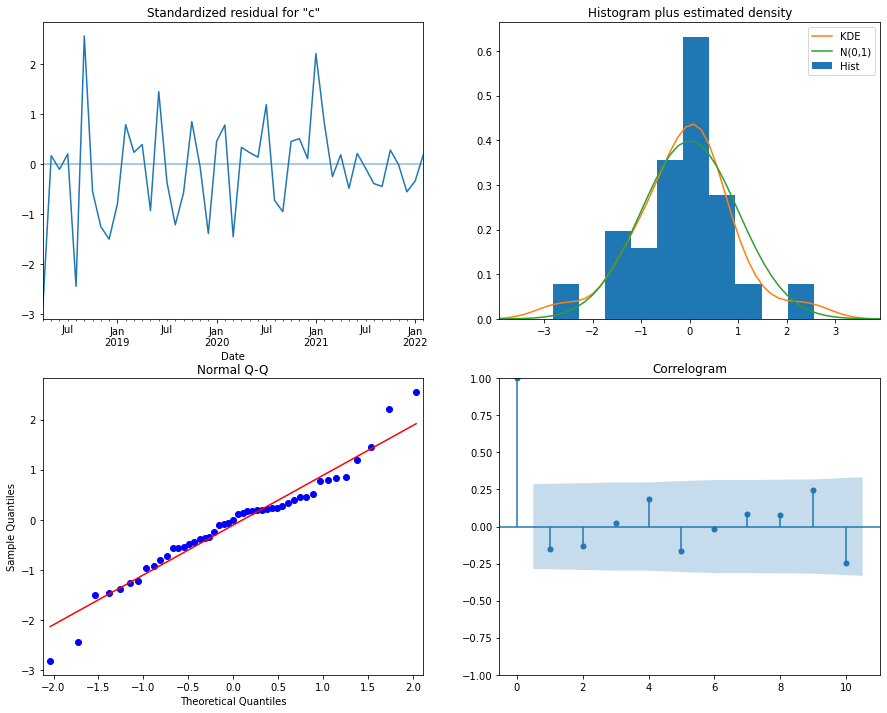

In [146]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

Dickey–Fuller test:: p=0.006095


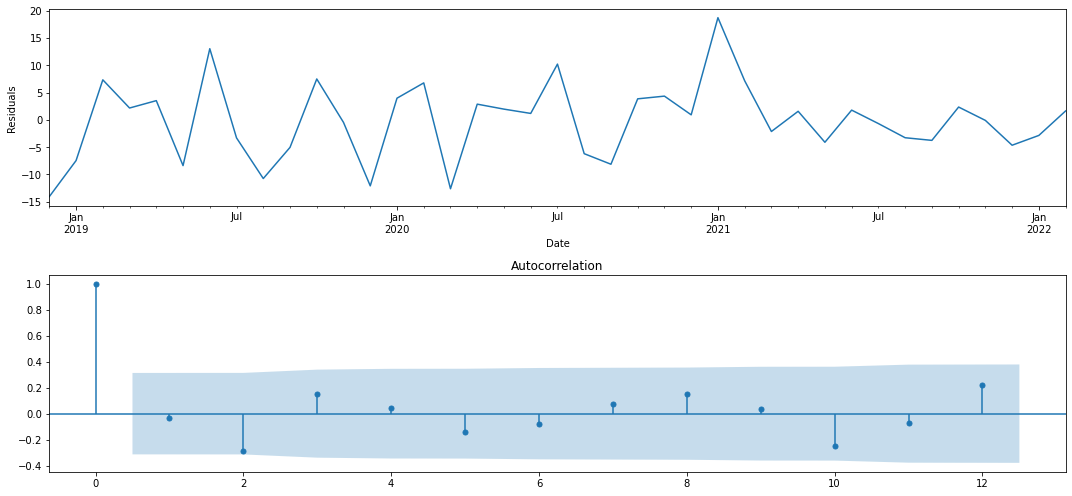

In [147]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
#sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)
plot_acf(best_model.resid[13:].values.squeeze(), lags=12, ax=ax)

print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

In [148]:
# Prediction
btc_month2 = btc_month[['Close']]
date_list = [datetime(2022, 3, 31), datetime(2022, 4, 30)]
future = pd.DataFrame(index=date_list, columns= btc_month.columns)
btc_month2 = pd.concat([btc_month2, future])

In [149]:
btc_month2['forecast'] = invboxcox(best_model.predict(start=0, end=92), lmbda)
btc_month2['forecast']

2017-11-30      1.000000
2017-12-31      0.001592
2018-01-31      0.005283
2018-02-28      0.009579
2018-03-31      0.001706
2018-04-30      0.101143
2018-05-31      0.004001
2018-06-30      0.003167
2018-07-31      0.002753
2018-08-31      0.007117
2018-09-30      0.002288
2018-10-31      0.006261
2018-11-30      0.004486
2018-12-31      0.003680
2019-01-31      0.002672
2019-02-28      0.001638
2019-03-31      0.001924
2019-04-30      0.002569
2019-05-31      0.003913
2019-06-30      0.002147
2019-07-31      0.003542
2019-08-31      0.004050
2019-09-30      0.002885
2019-10-31      0.002040
2019-11-30      0.002597
2019-12-31      0.003099
2020-01-31      0.002094
2020-02-29      0.002209
2020-03-31      0.002804
2020-04-30      0.001906
2020-05-31      0.002384
2020-06-30      0.002404
2020-07-31      0.002311
2020-08-31      0.004373
2020-09-30      0.003684
2020-10-31      0.002338
2020-11-30      0.002617
2020-12-31      0.003682
2021-01-31      0.004418
2021-02-28      0.021045


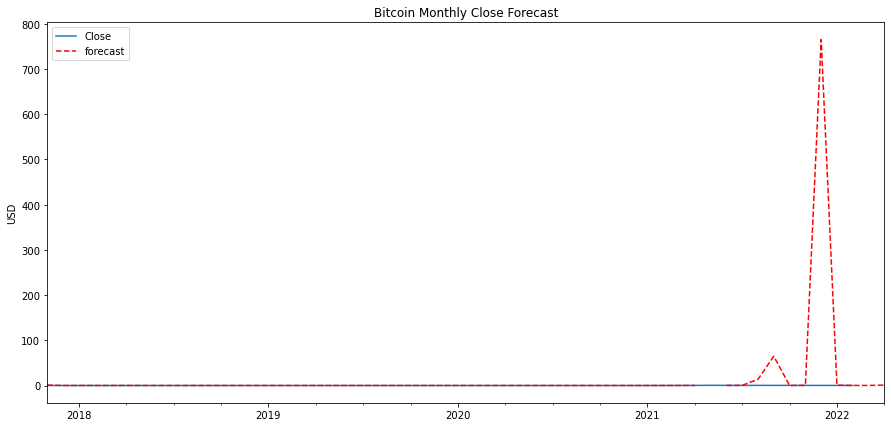

In [150]:
# Prediction
btc_month2 = btc_month[['Close']]
date_list = [datetime(2022, 3, 31), datetime(2022, 4, 30)]
future = pd.DataFrame(index=date_list, columns= btc_month.columns)
btc_month2 = pd.concat([btc_month2, future])

btc_month2['forecast'] = invboxcox(best_model.predict(start=0, end=92), lmbda)

plt.figure(figsize=(15,7))
btc_month2.Close.plot()
btc_month2.forecast.plot(color='r', ls='--', label='forecast')
plt.legend()
plt.title('Bitcoin Monthly Close Forecast')
plt.ylabel('USD')
plt.savefig('bitcoin_monthly_forecast.png')
plt.show()

In [151]:
y_forecasted = btc_month2['2014-10-31':'2022-02-28'].forecast
y_truth = btc_month2['2014-10-31':'2022-02-28'].Close

# Compute the root mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('Mean Squared Error: {}'.format(round(rmse, 2)))

Mean Squared Error: 107.49


In [152]:
y_forecasted = btc_month2['2014-11-30':'2022-02-28'].forecast
y_truth = btc_month2['2014-10-31':'2022-02-28'].Close

# Compute the root mean square error
rmse = np.sqrt(((y_forecasted - y_truth.shift(1)) ** 2).mean())
print('Mean Squared Error: {}'.format(round(rmse, 2)))

Mean Squared Error: 108.55


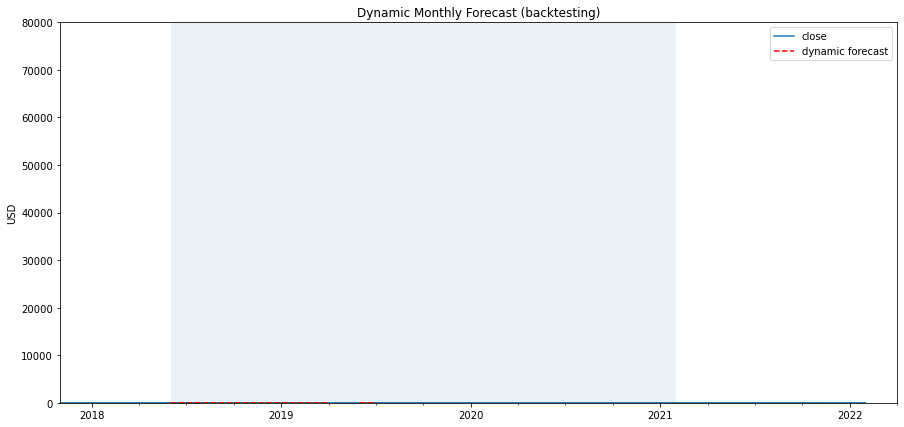

In [153]:
# Get the dynamic forecast between dates t1 and t2
t1 = pd.to_datetime('2018-06-30')
t2 = pd.to_datetime('2021-02-28')
btc_month_dynamic = best_model.get_prediction(start=t1, end=t2, dynamic=True, full_results=True)
btc_month2['dynamic_forecast'] = invboxcox(btc_month_dynamic.predicted_mean, lmbda)

# Taking 80% confidence interval because the 95% blows out too high to visualise
pred_dynamic_ci = btc_month_dynamic.conf_int(alpha=0.2)
pred_dynamic_ci['lower close_box'] = invboxcox(pred_dynamic_ci['lower close_box'], lmbda)
pred_dynamic_ci['upper close_box'] = invboxcox(pred_dynamic_ci['upper close_box'], lmbda)

# Plot
plt.figure(figsize=(15,7))
plt.ylim((0,80000))

btc_month2.Close['2017':'2022'].plot(label='close')
btc_month2.dynamic_forecast.plot(color='r', ls='--', label='dynamic forecast')

plt.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
plt.fill_betweenx(plt.ylim(), t1, t2, alpha=.1, zorder=-1)

plt.legend()
plt.title('Dynamic Monthly Forecast (backtesting)')
plt.ylabel('USD')
plt.show()


In [34]:
z = ['ADA-USD','BNB-USD','BTC-USD','DAI-USD','DOGE-USD','ETH-USD','HEX-USD','SHIB-USD','TRX-USD','USDC-USD','XRP-USD']

In [35]:
def model(ticker):
  path = "C:/Users/Anil/Desktop/cryptoDataCollection (2)/top 5/"
  csv = '.csv'
  ticker = ticker
  btc = pd.read_csv(path+ticker+csv)
  print('---------------------------------------------------------------------------------')
  print(ticker)
  btc['Date'] = pd.to_datetime(btc['Date'], format='%Y-%m-%d')
  btc = btc.set_index('Date')
  # Resampling to monthly frequency
  btc_month = btc.resample('M').mean()
  #seasonal_decompose(btc_month.close, freq=12).plot()
  seasonal_decompose(btc_month.Close).plot()
  print("Dickey–Fuller test: p=%f" % adfuller(btc_month.Close)[1])
  plt.show()
  # Box-Cox Transformations
  btc_month['close_box'], lmbda = stats.boxcox(btc_month.Close)
  print("Dickey–Fuller test: p=%f" % adfuller(btc_month.close_box)[1])
  # Seasonal differentiation (12 months)
  btc_month['box_diff_seasonal_12'] = btc_month.close_box - btc_month.close_box.shift(12)
  print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_12[12:])[1])
  # Seasonal differentiation (3 months)
  btc_month['box_diff_seasonal_3'] = btc_month.close_box - btc_month.close_box.shift(3)
  print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_3[3:])[1])
  # Regular differentiation
  btc_month['box_diff2'] = btc_month.box_diff_seasonal_12 - btc_month.box_diff_seasonal_12.shift(1)

  # STL-decomposition
  seasonal_decompose(btc_month.box_diff2[13:]).plot()   
  print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff2[13:])[1])

  plt.show()
  #autocorrelation_plot(btc_month.close)
  plot_acf(btc_month.Close[13:].values.squeeze(), lags=12)

  plt.tight_layout()
  plt.show()
  # Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
  ax = plt.subplot(211)
# Plot the autocorrelation function
#sm.graphics.tsa.plot_acf(btc_month.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
  plot_acf(btc_month.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
  ax = plt.subplot(212)
  #sm.graphics.tsa.plot_pacf(btc_month.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
  plot_pacf(btc_month.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
  plt.tight_layout()
  plt.show()
  # Initial approximation of parameters
  qs = range(0, 3)
  ps = range(0, 3)
  d=1
  parameters = product(ps, qs)
  parameters_list = list(parameters)
  len(parameters_list)

# Model Selection
  results = []
  AIC = []
  best_aic = float("inf")
  warnings.filterwarnings('ignore')
  for param in parameters_list:
      try:
          model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1])).fit(disp=-1)
      except ValueError:
          print('bad parameter combination:', param)
          continue
      aic = model.aic
      if aic < best_aic:
          best_model = model
          best_aic = aic
          best_param = param
      results.append([param, model.aic])
      AIC.append([aic])
  # Best Models
  result_table = pd.DataFrame(results)
  result_table.columns = ['parameters', 'aic']
  print(result_table.sort_values(by = 'aic', ascending=True).head())
  print(best_model.summary())
  print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])
  best_model.plot_diagnostics(figsize=(15, 12))
  plt.show()
  # Inverse Box-Cox Transformation Function
  def invboxcox(y,lmbda):
     if lmbda == 0:
        return(np.exp(y))
     else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))
  # Prediction
  btc_month_pred = btc_month[['Close']]
  #date_list = [datetime(2018, 3, 31), datetime(2018, 4, 30), datetime(2018, 5, 31), datetime(2018, 6, 30), 
  #             datetime(2018, 7, 31), datetime(2018, 8, 31), datetime(2018, 9, 30), datetime(2018, 10, 31),
  #             datetime(2018, 11, 30), datetime(2018, 12, 31)]
  date_list = [datetime(2022, 3, 31), datetime(2022, 4, 30), datetime(2022, 5, 31), datetime(2022, 6, 30)]
  future = pd.DataFrame(index=date_list, columns= btc_month.columns)
  btc_month_pred = pd.concat([btc_month_pred, future])

  btc_month_pred['forecast'] = invboxcox(best_model.predict(start=0, end=120), lmbda)


  plt.figure(figsize=(15,7))
  btc_month_pred.Close.plot()
  btc_month_pred.forecast.plot(color='r', ls='--', label='Predicted Close')
  plt.legend()
  plt.title('Monthly forecast')
  plt.ylabel('USD')
  plt.show()

  # Initial approximation of parameters
  Qs = range(0, 2)
  qs = range(0, 3)
  Ps = range(0, 3)
  ps = range(0, 3)
  D=1
  d=1
  parameters = product(ps, qs, Ps, Qs)
  parameters_list = list(parameters)
  len(parameters_list)

# Model Selection
  results_sarima = []
  best_aic = float("inf")
  warnings.filterwarnings('ignore')
  for param in parameters_list:
      try:
  #        model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
          model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 4)).fit(disp=-1)
      except ValueError:
          print('bad parameter combination:', param)
          continue
      aic = model.aic
      if aic < best_aic:
          best_model = model
          best_aic = aic
          best_param = param
      results_sarima.append([param, model.aic])
      
  best_model.plot_diagnostics(figsize=(15, 12))
  plt.show()
  # Best Models
  result_table = pd.DataFrame(results_sarima)
  result_table.columns = ['parameters', 'aic']
  print(result_table.sort_values(by = 'aic', ascending=True).head())
  print(best_model.summary())
  # STL-decomposition
  plt.figure(figsize=(15,7))
  plt.subplot(211)
  best_model.resid[13:].plot()
  plt.ylabel(u'Residuals')
  ax = plt.subplot(212)
  #sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)
  plot_acf(best_model.resid[13:].values.squeeze(), lags=12, ax=ax)

  print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

  plt.tight_layout()
  plt.show()
  # Prediction
  btc_month2 = btc_month[['Close']]
  date_list = [datetime(2022, 3, 31), datetime(2022, 4, 30)]
  future = pd.DataFrame(index=date_list, columns= btc_month.columns)
  btc_month2 = pd.concat([btc_month2, future])

  btc_month2['forecast'] = invboxcox(best_model.predict(start=0, end=92), lmbda)

  plt.figure(figsize=(15,7))
  btc_month2.Close.plot()
  btc_month2.forecast.plot(color='r', ls='--', label='forecast')
  plt.legend()
  plt.title('Monthly Close Forecast')
  plt.ylabel('USD')
  plt.savefig('Monthly_forecast.png')
  plt.show()
  y_forecasted = btc_month2['2014-10-31':'2022-02-28'].forecast
  y_truth = btc_month2['2014-10-31':'2022-02-28'].Close

# Compute the root mean square error
  rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
  print('Mean Squared Error: {}'.format(round(rmse, 2)))

  # Get the dynamic forecast between dates t1 and t2
  t1 = pd.to_datetime('2018-06-30')
  t2 = pd.to_datetime('2021-02-28')
  btc_month_dynamic = best_model.get_prediction(start=t1, end=t2, dynamic=True, full_results=True)
  btc_month2['dynamic_forecast'] = invboxcox(btc_month_dynamic.predicted_mean, lmbda)

# Taking 80% confidence interval because the 95% blows out too high to visualise
  pred_dynamic_ci = btc_month_dynamic.conf_int(alpha=0.2)
  pred_dynamic_ci['lower close_box'] = invboxcox(pred_dynamic_ci['lower close_box'], lmbda)
  pred_dynamic_ci['upper close_box'] = invboxcox(pred_dynamic_ci['upper close_box'], lmbda)

# Plot
  plt.figure(figsize=(15,7))
  plt.ylim((0,max(btc.Close)))

  btc_month2.Close['2017':'2022'].plot(label='close')
  btc_month2.dynamic_forecast.plot(color='r', ls='--', label='dynamic forecast')

  plt.fill_between(pred_dynamic_ci.index,
                  pred_dynamic_ci.iloc[:, 0],
                  pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
  plt.fill_betweenx(plt.ylim(), t1, t2, alpha=.1, zorder=-1)

  plt.legend()
  plt.title('Dynamic Monthly Forecast (backtesting)')
  plt.ylabel('USD')
  plt.show()
  plt.savefig("Dynamic Monthly Forecast (backtesting)",)


---------------------------------------------------------------------------------
ADA-USD
Dickey–Fuller test: p=0.005037


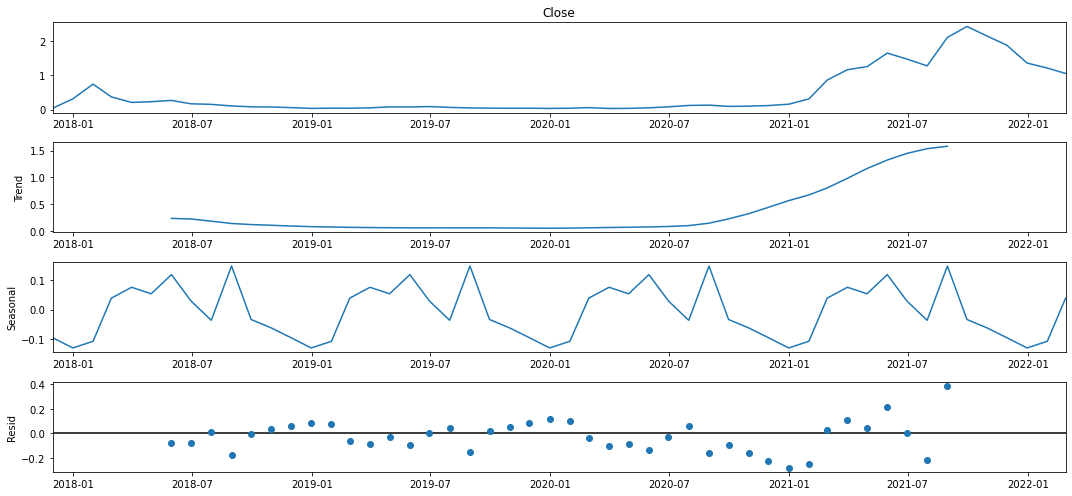

Dickey–Fuller test: p=0.660148
Dickey–Fuller test: p=0.361426
Dickey–Fuller test: p=0.004527
Dickey–Fuller test: p=0.304671


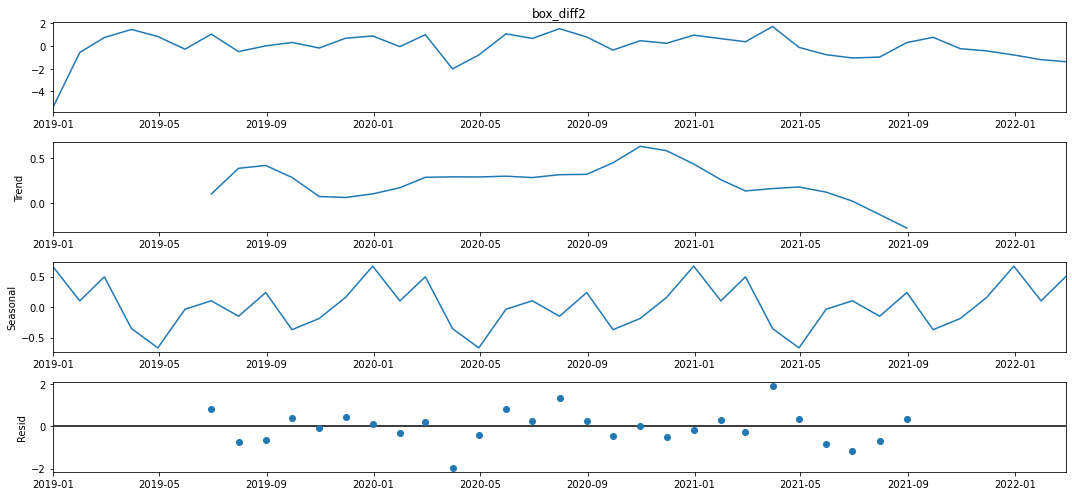

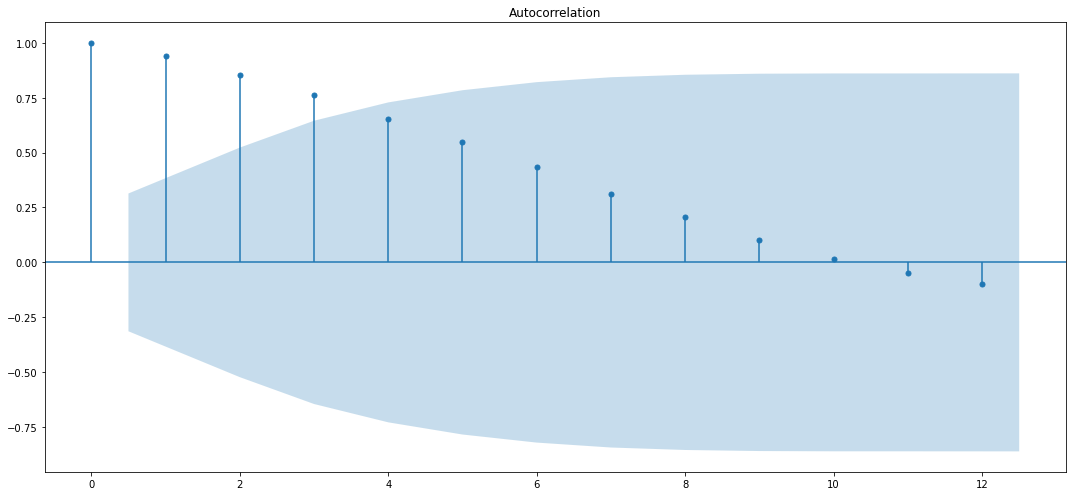

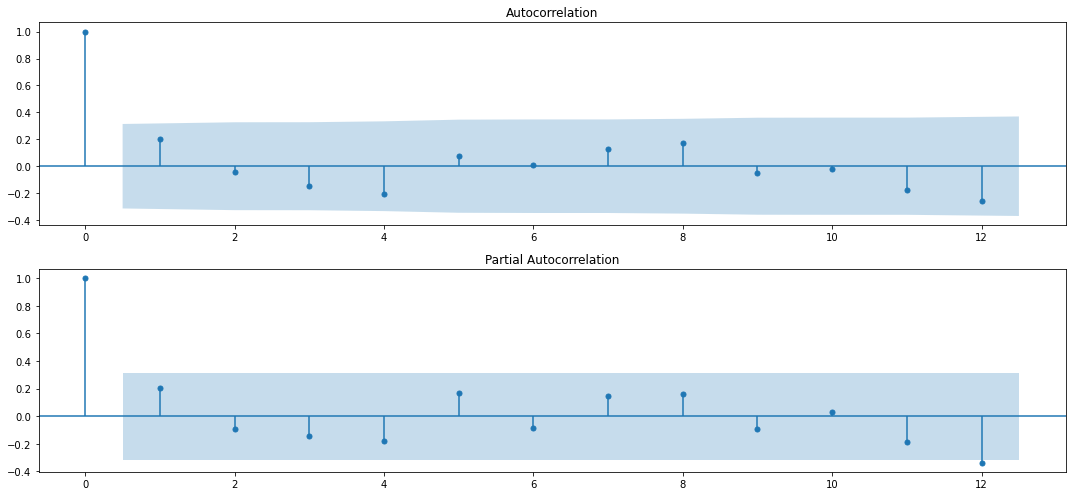

  parameters         aic
1     (0, 1)  121.238783
4     (1, 1)  123.039626
2     (0, 2)  123.057873
6     (2, 0)  124.237917
5     (1, 2)  124.629138
                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   52
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 -58.619
Date:                Mon, 23 May 2022   AIC                            121.239
Time:                        18:16:40   BIC                            125.102
Sample:                    11-30-2017   HQIC                           122.715
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6313      0.125      5.043      0.000      

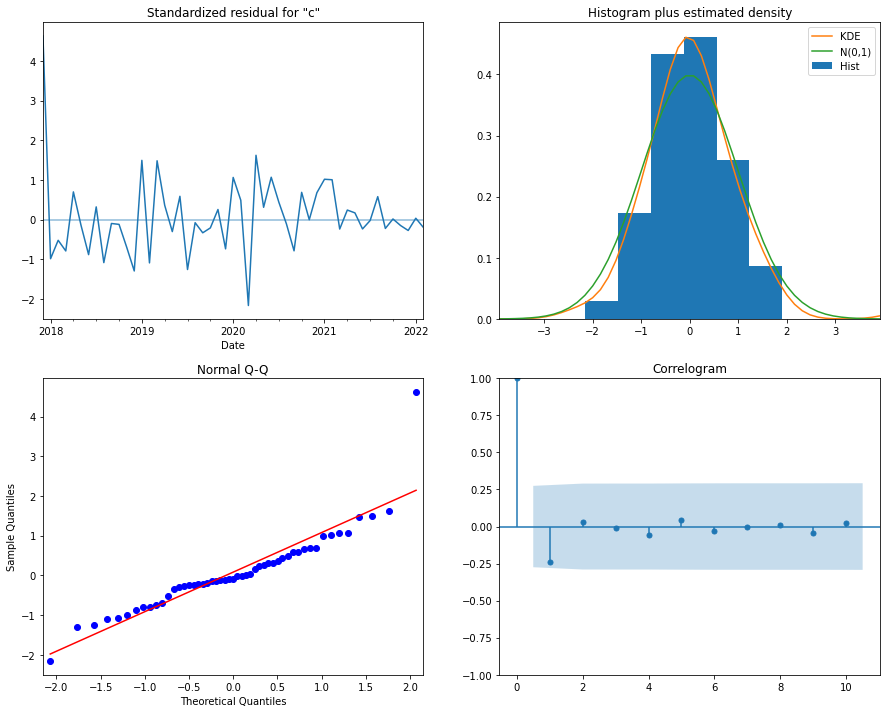

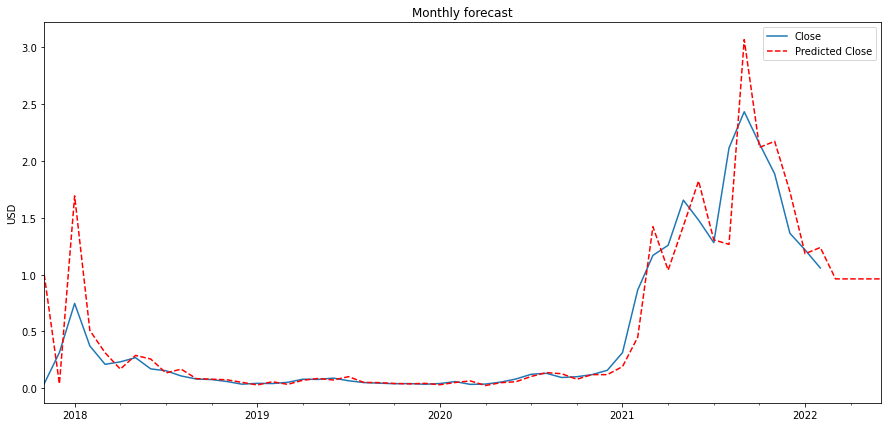

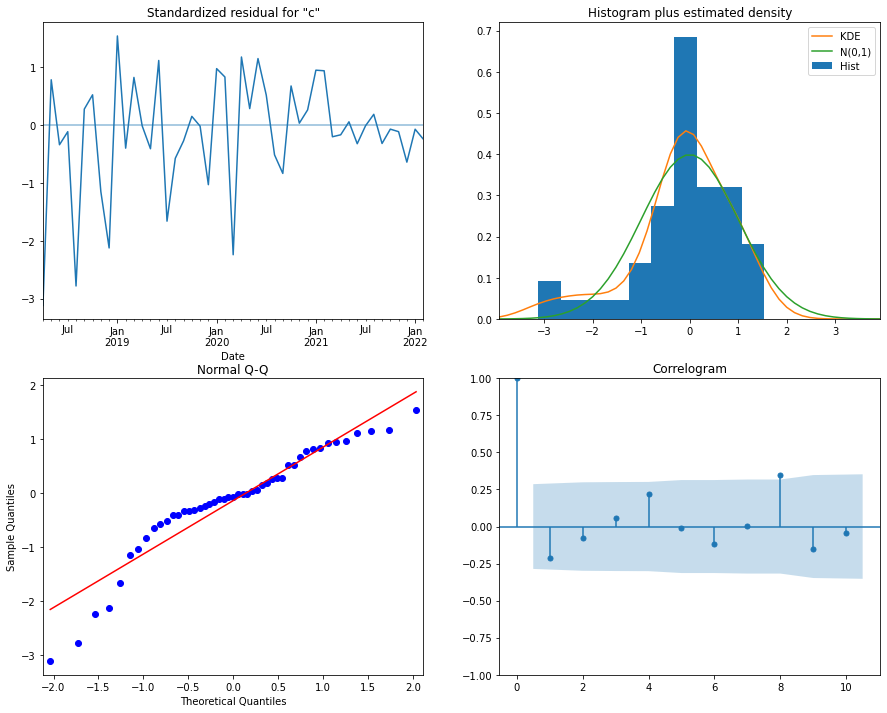

      parameters         aic
7   (0, 1, 0, 1)  126.829519
9   (0, 1, 1, 1)  128.623281
13  (0, 2, 0, 1)  128.667196
25  (1, 1, 0, 1)  128.668842
37  (2, 0, 0, 1)  129.699486
                                     SARIMAX Results                                     
Dep. Variable:                         close_box   No. Observations:                   52
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 4)   Log Likelihood                 -60.415
Date:                           Mon, 23 May 2022   AIC                            126.830
Time:                                   18:16:55   BIC                            132.380
Sample:                               11-30-2017   HQIC                           128.918
                                    - 02-28-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------

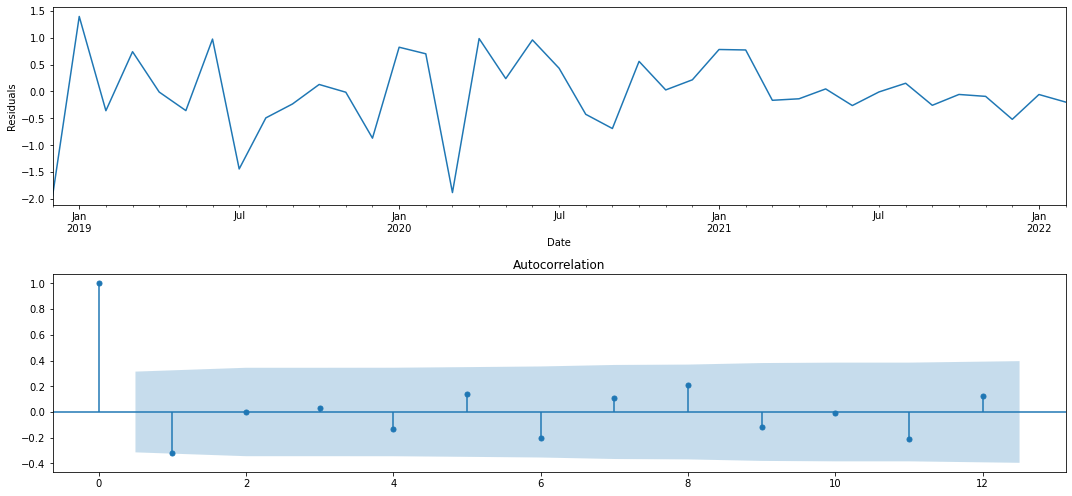

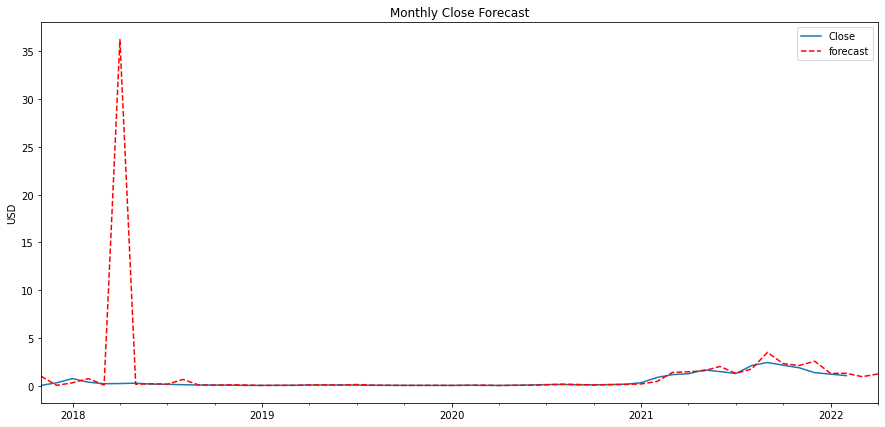

Mean Squared Error: 5.0


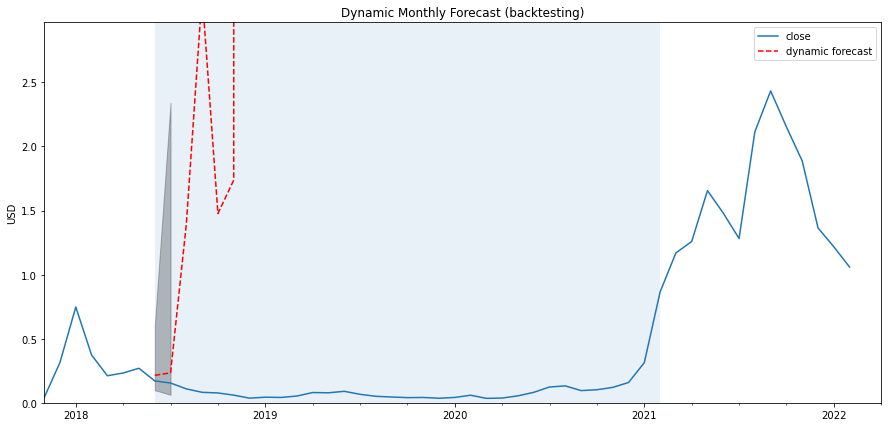

---------------------------------------------------------------------------------
BNB-USD
Dickey–Fuller test: p=0.870784


<Figure size 1080x504 with 0 Axes>

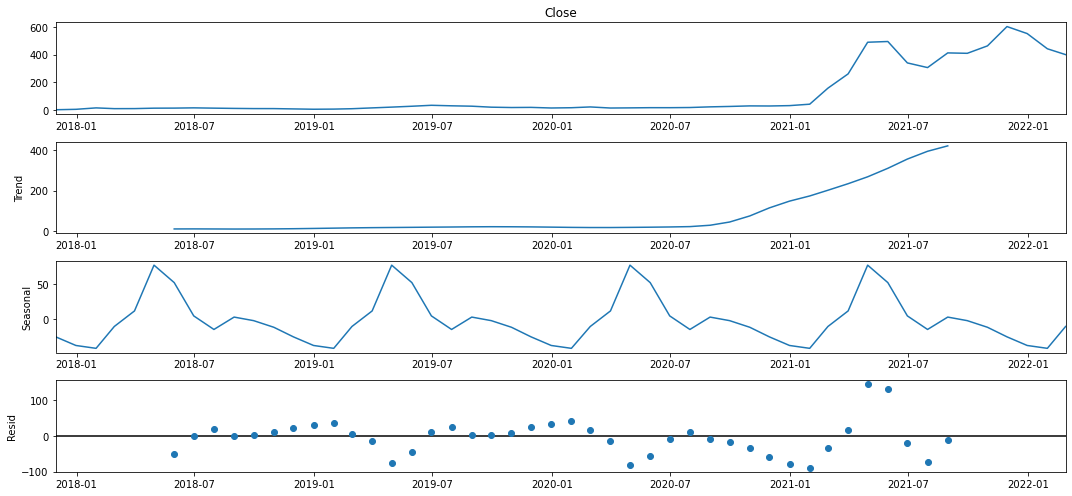

Dickey–Fuller test: p=0.680684
Dickey–Fuller test: p=0.086842
Dickey–Fuller test: p=0.004857
Dickey–Fuller test: p=0.000008


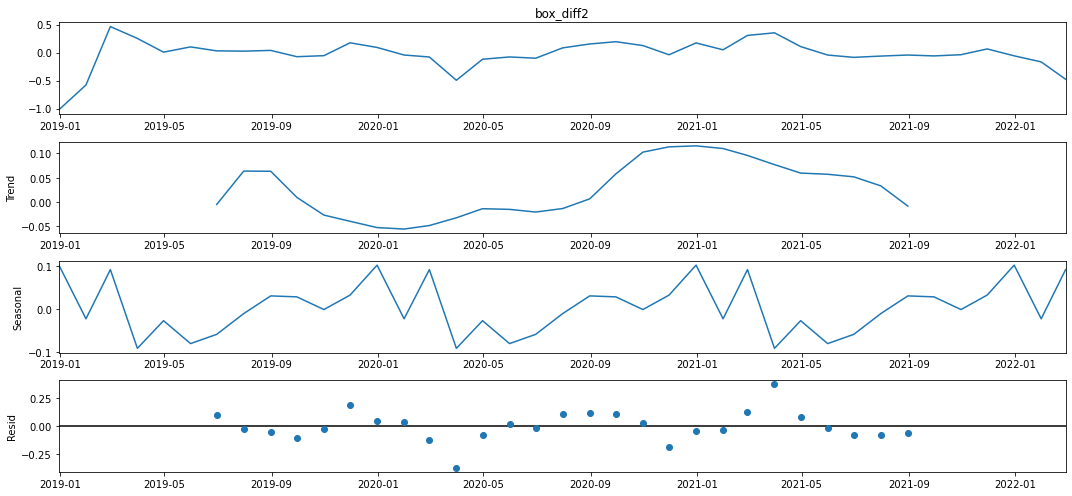

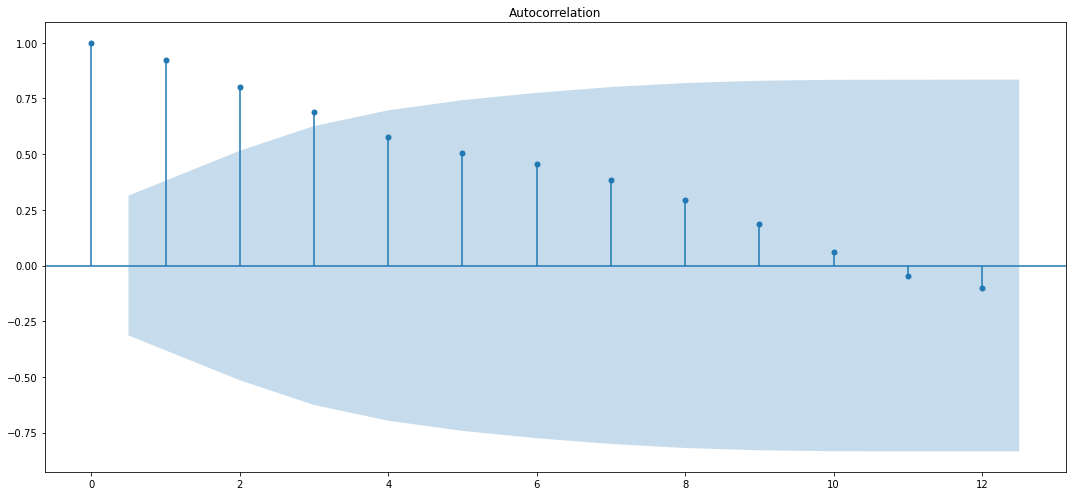

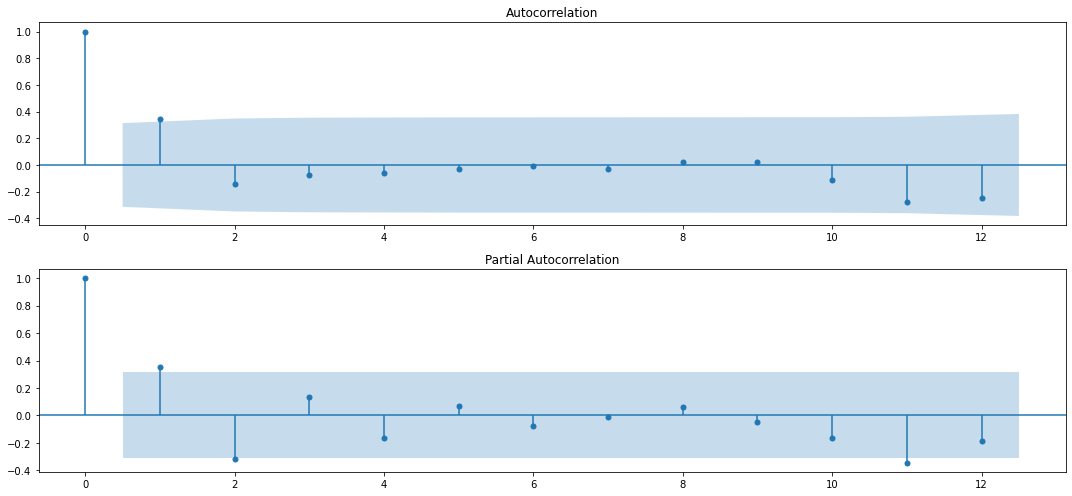

  parameters        aic
1     (0, 1) -32.733119
8     (2, 2) -31.328329
4     (1, 1) -30.760022
2     (0, 2) -30.758324
3     (1, 0) -30.054634
                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   52
Model:               SARIMAX(0, 1, 1)   Log Likelihood                  18.367
Date:                Mon, 23 May 2022   AIC                            -32.733
Time:                        18:16:59   BIC                            -28.869
Sample:                    11-30-2017   HQIC                           -31.257
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5779      0.134      4.311      0.000       0.315

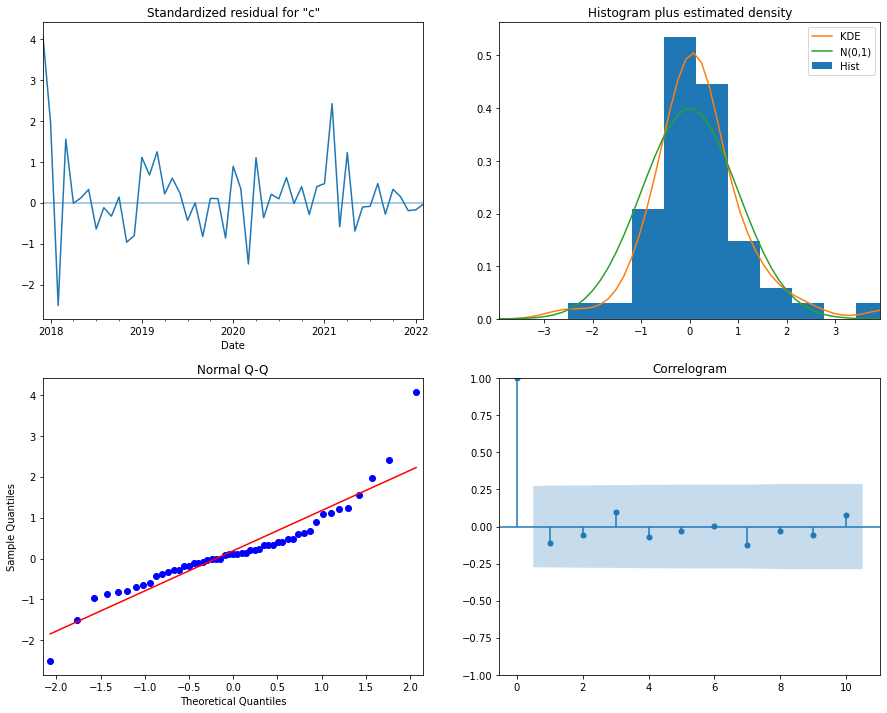

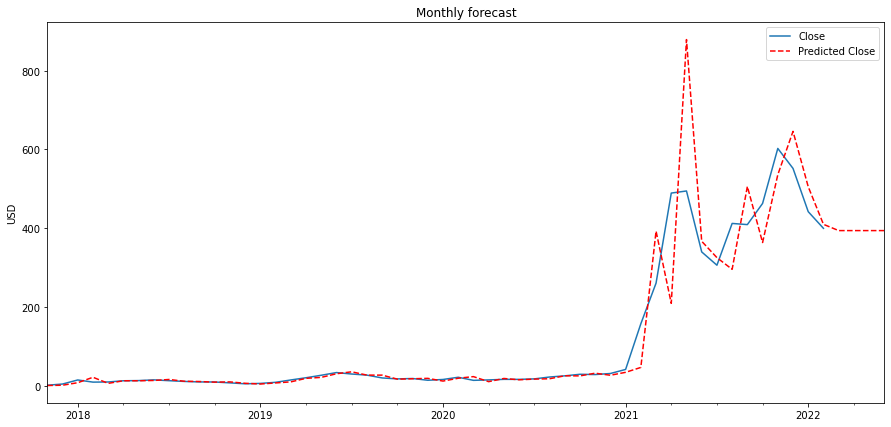

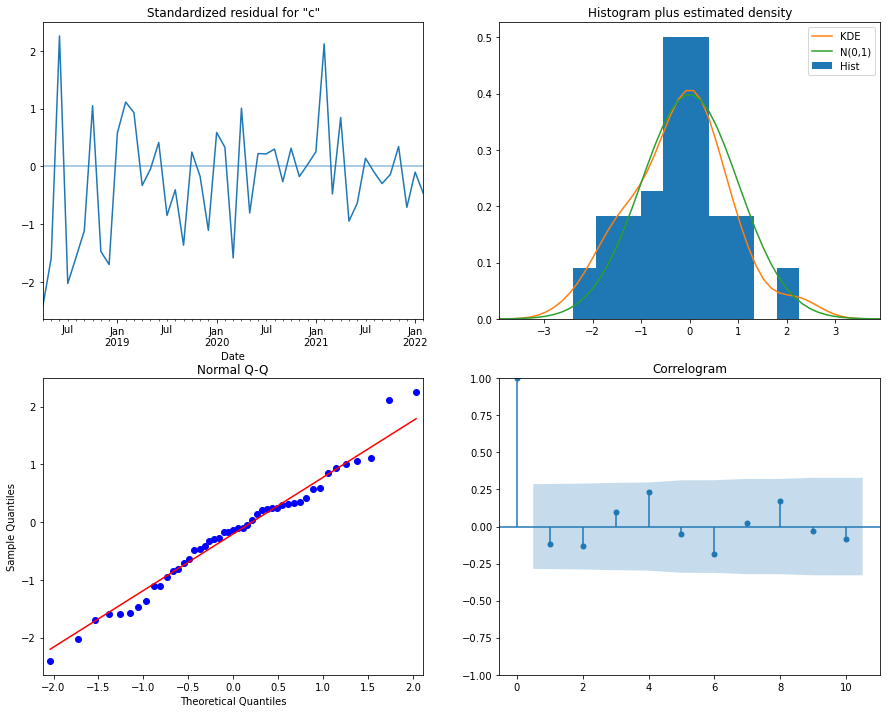

      parameters        aic
7   (0, 1, 0, 1) -17.707964
25  (1, 1, 0, 1) -16.422243
13  (0, 2, 0, 1) -16.413848
9   (0, 1, 1, 1) -15.760022
10  (0, 1, 2, 0) -14.966858
                                     SARIMAX Results                                     
Dep. Variable:                         close_box   No. Observations:                   52
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 4)   Log Likelihood                  11.854
Date:                           Mon, 23 May 2022   AIC                            -17.708
Time:                                   18:17:13   BIC                            -12.158
Sample:                               11-30-2017   HQIC                           -15.619
                                    - 02-28-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------

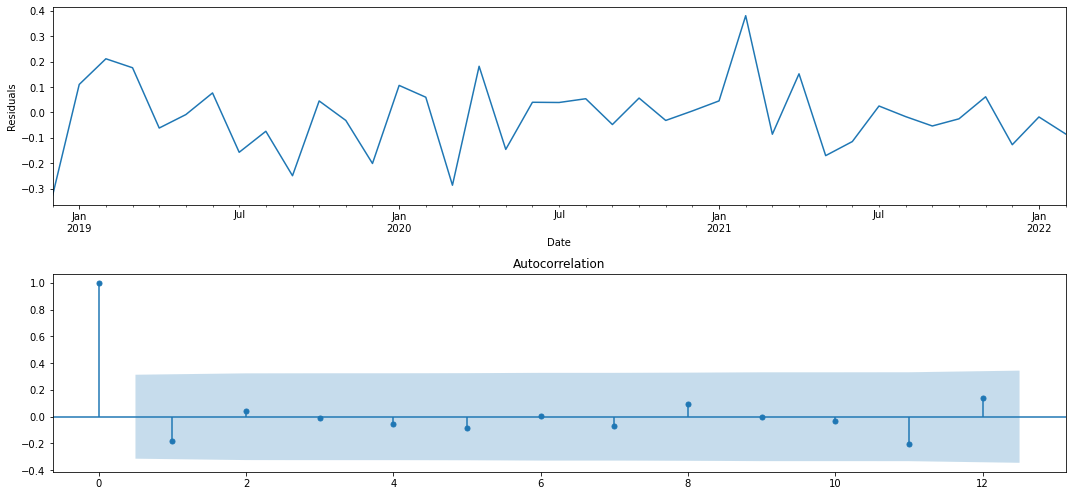

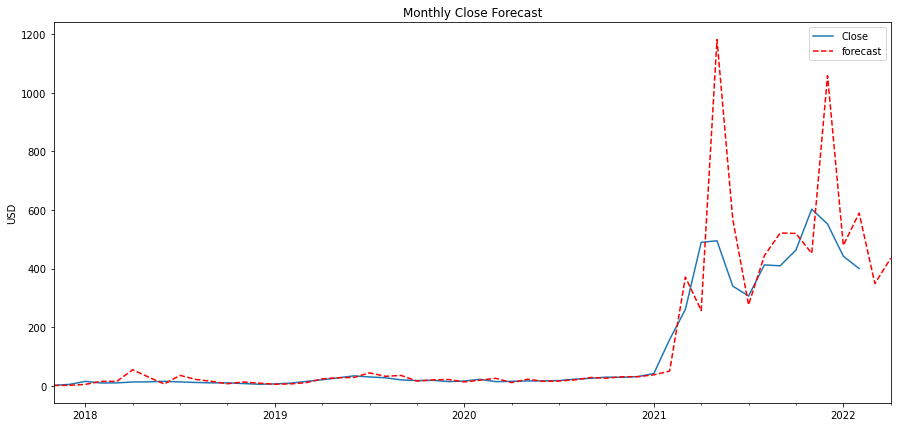

Mean Squared Error: 134.27


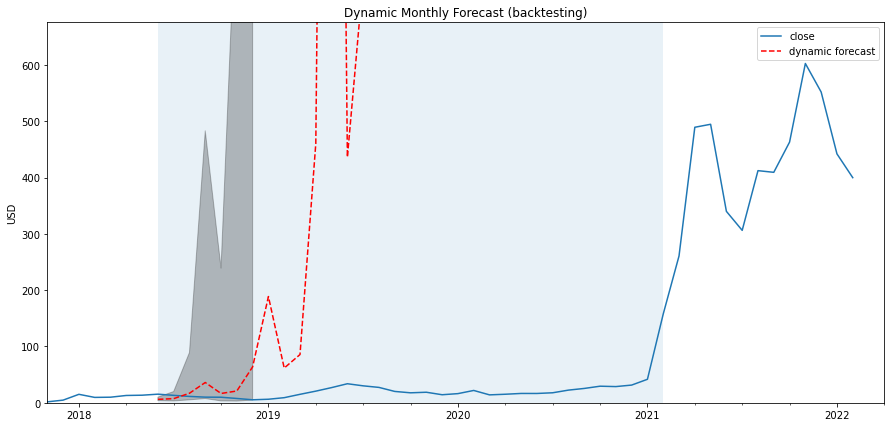

---------------------------------------------------------------------------------
BTC-USD
Dickey–Fuller test: p=0.997898


<Figure size 1080x504 with 0 Axes>

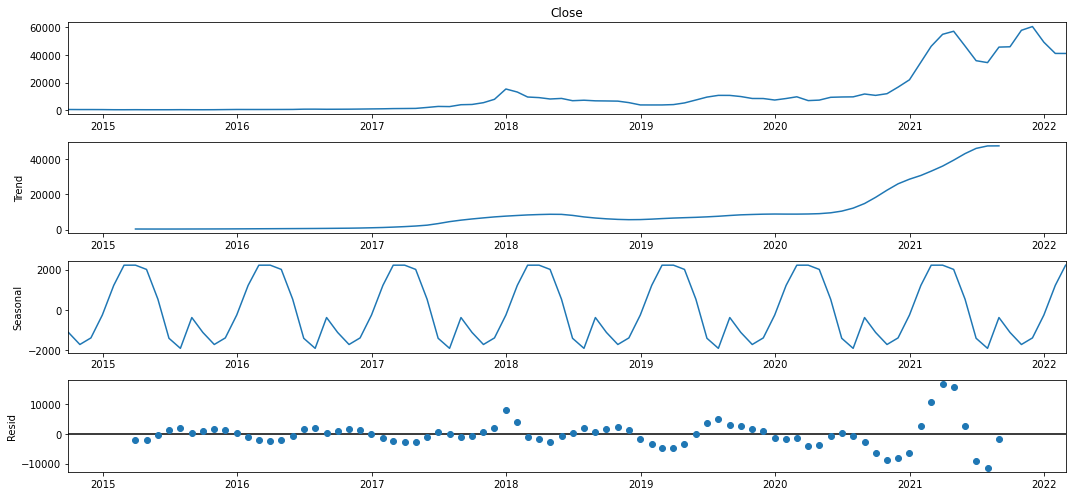

Dickey–Fuller test: p=0.843916
Dickey–Fuller test: p=0.093750
Dickey–Fuller test: p=0.004600
Dickey–Fuller test: p=0.001096


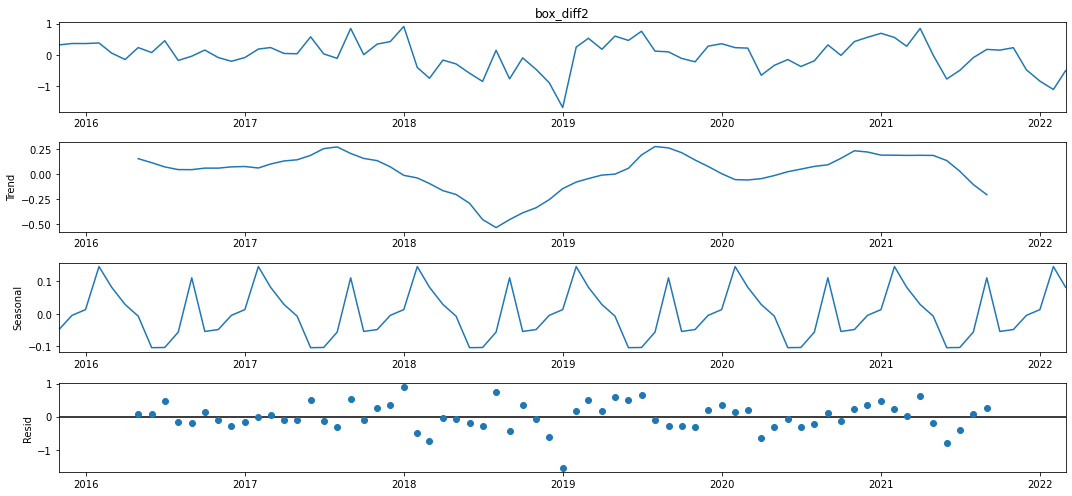

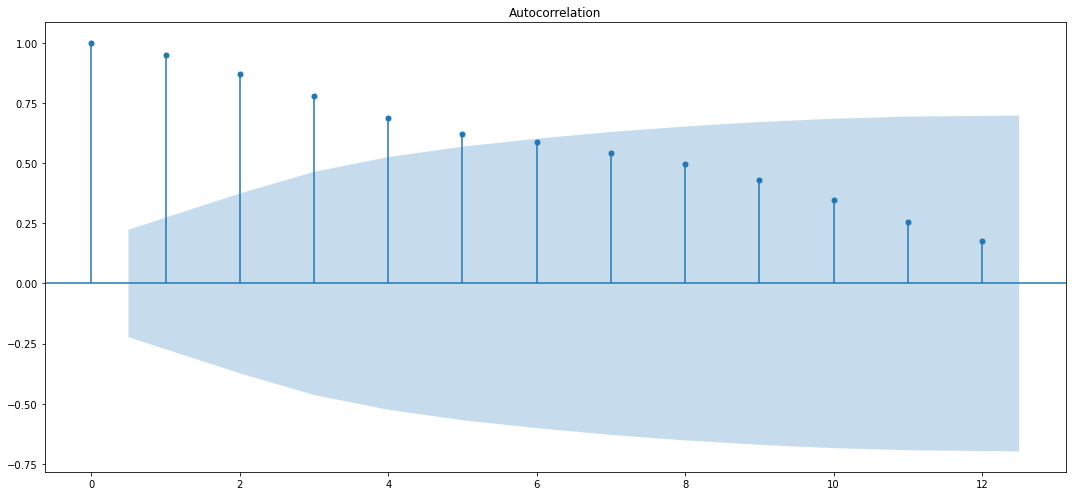

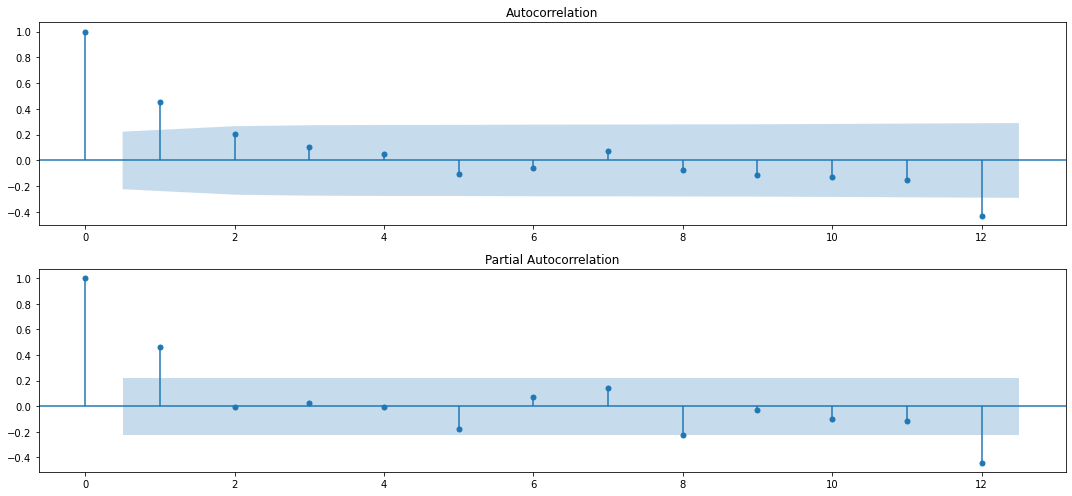

  parameters        aic
3     (1, 0)  34.991905
1     (0, 1)  35.994185
7     (2, 1)  36.208355
4     (1, 1)  36.941868
6     (2, 0)  36.963707
                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   90
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 -15.496
Date:                Mon, 23 May 2022   AIC                             34.992
Time:                        18:17:17   BIC                             39.969
Sample:                    09-30-2014   HQIC                            36.998
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4048      0.073      5.518      0.000       0.261

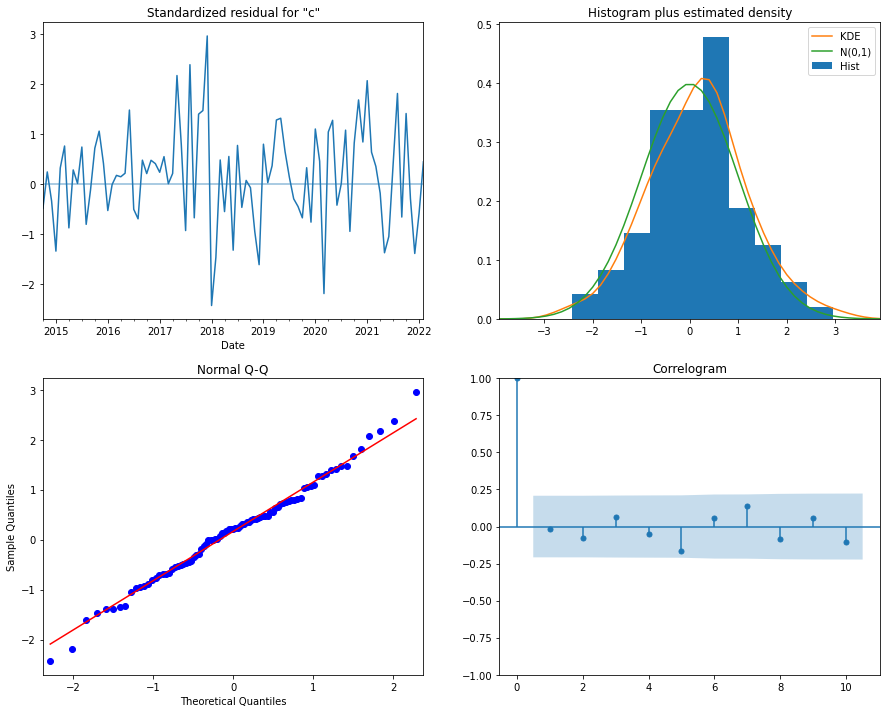

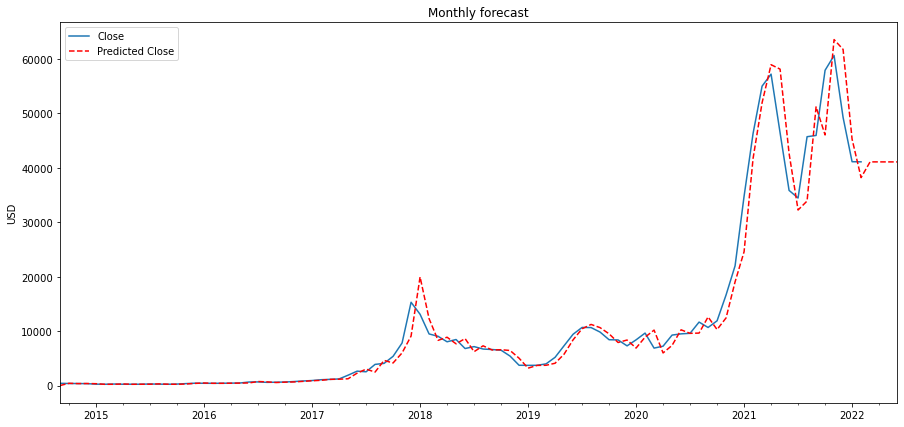

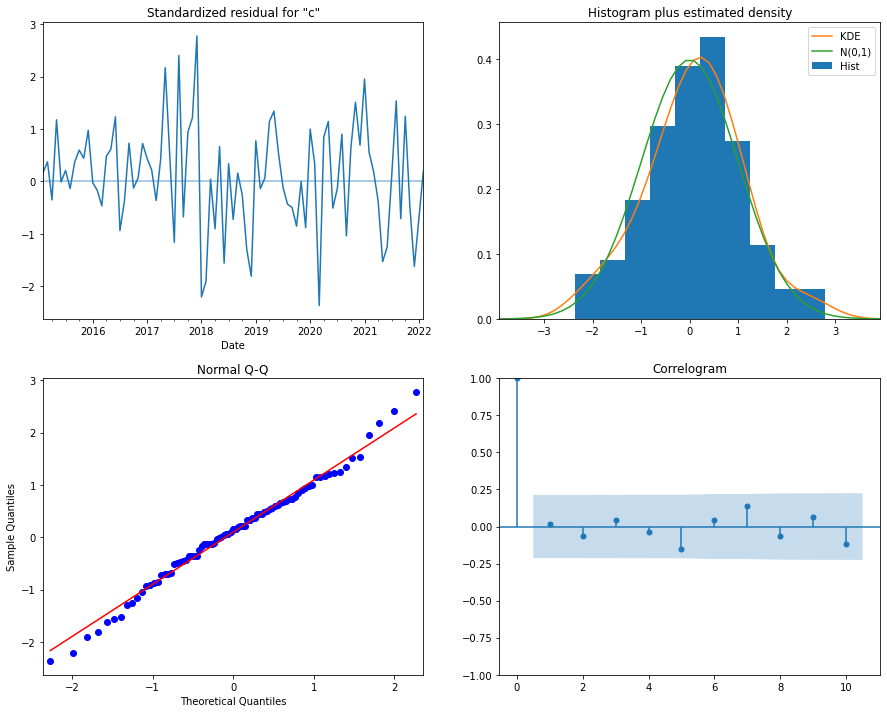

      parameters        aic
19  (1, 0, 0, 1)  49.102947
7   (0, 1, 0, 1)  49.142053
25  (1, 1, 0, 1)  50.802587
13  (0, 2, 0, 1)  50.896880
37  (2, 0, 0, 1)  50.913727
                                      SARIMAX Results                                      
Dep. Variable:                           close_box   No. Observations:                   90
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 4)   Log Likelihood                 -21.551
Date:                             Mon, 23 May 2022   AIC                             49.103
Time:                                     18:17:35   BIC                             56.431
Sample:                                 09-30-2014   HQIC                            52.050
                                      - 02-28-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------

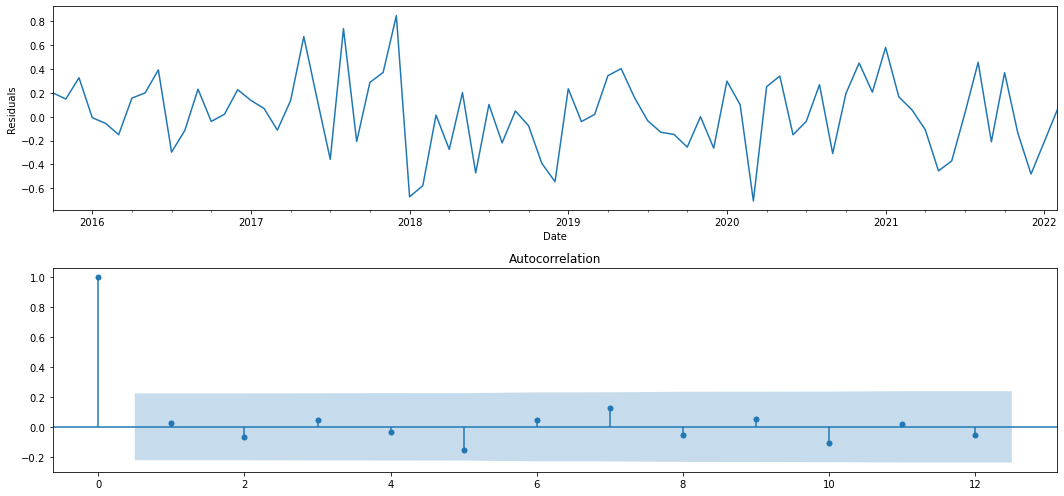

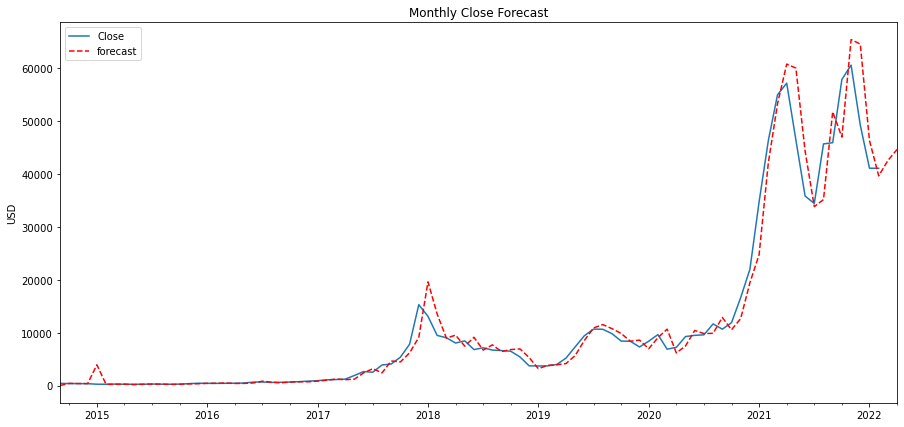

Mean Squared Error: 3579.95


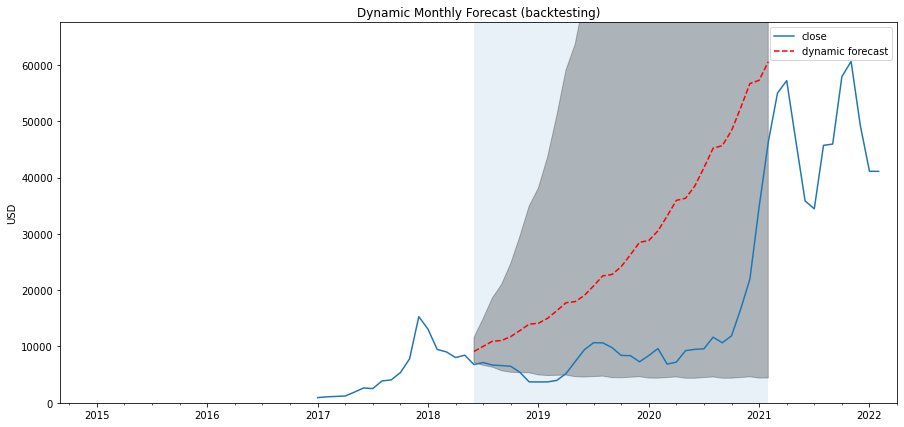

---------------------------------------------------------------------------------
DAI-USD
Dickey–Fuller test: p=0.180502


<Figure size 1080x504 with 0 Axes>

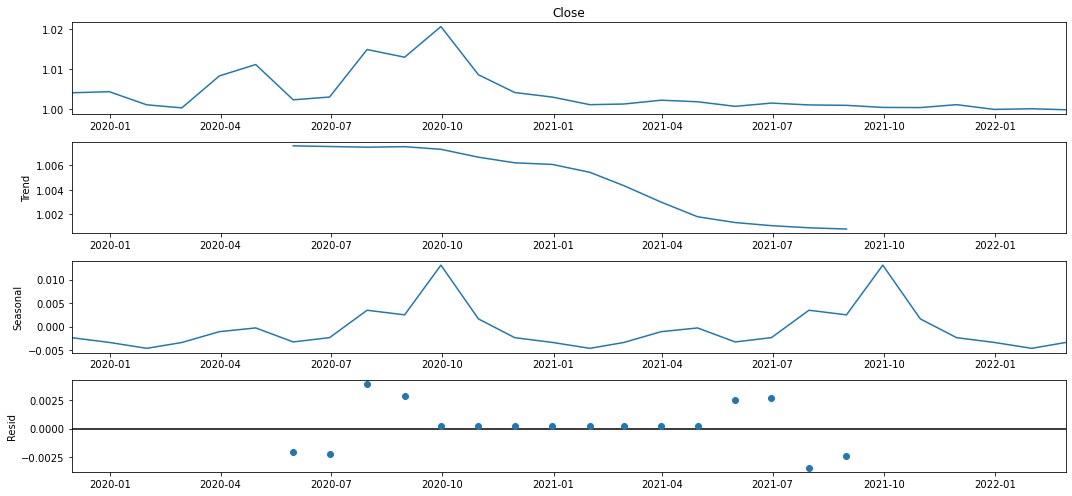

Dickey–Fuller test: p=0.343211
Dickey–Fuller test: p=0.261663
Dickey–Fuller test: p=0.000000
---------------------------------------------------------------------------------
DOGE-USD
Dickey–Fuller test: p=0.408376


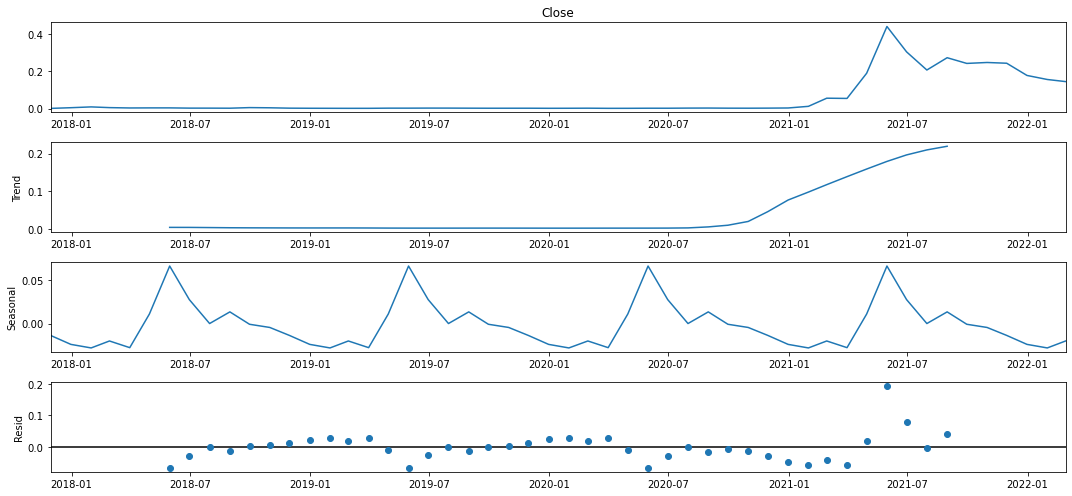

Dickey–Fuller test: p=0.874895
Dickey–Fuller test: p=0.564916
Dickey–Fuller test: p=0.000479
Dickey–Fuller test: p=0.224464


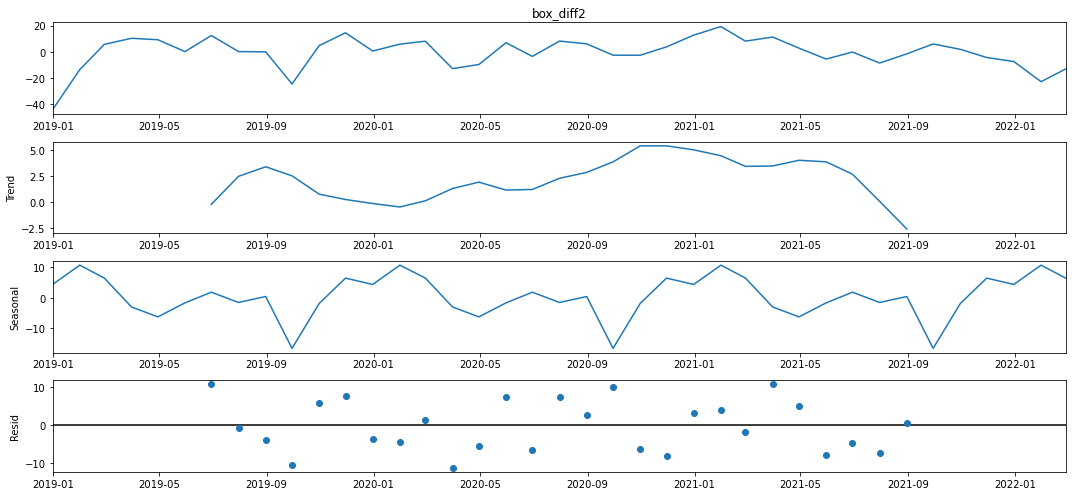

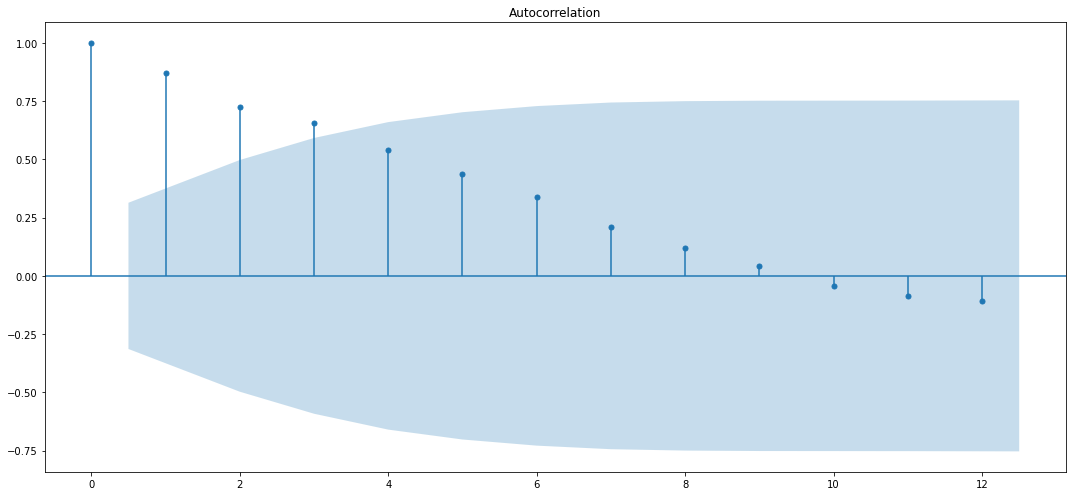

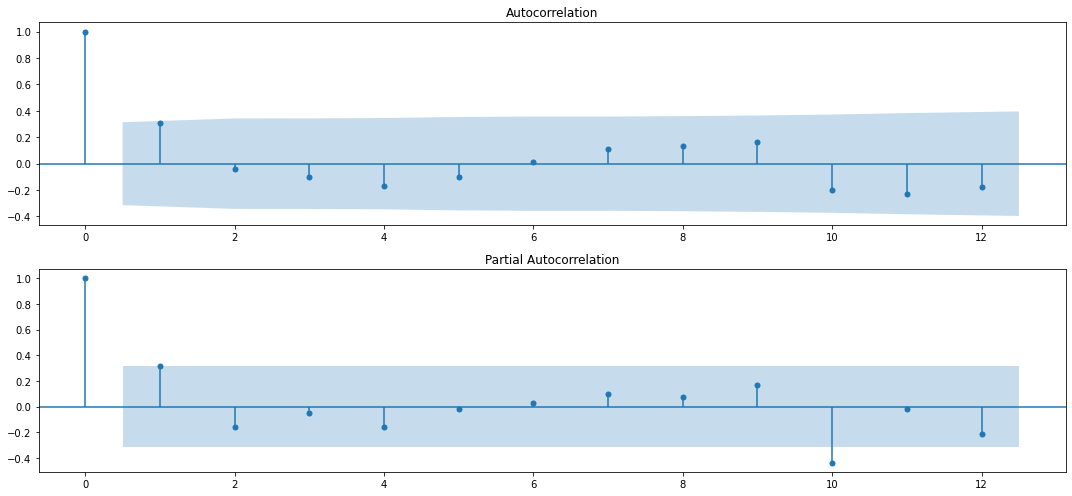

  parameters         aic
4     (1, 1)  361.111888
1     (0, 1)  361.967044
5     (1, 2)  362.618471
6     (2, 0)  363.170648
2     (0, 2)  363.233672
                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   52
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -177.556
Date:                Mon, 23 May 2022   AIC                            361.112
Time:                        18:17:41   BIC                            366.907
Sample:                    11-30-2017   HQIC                           363.327
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5837      0.141     -4.138      0.000      

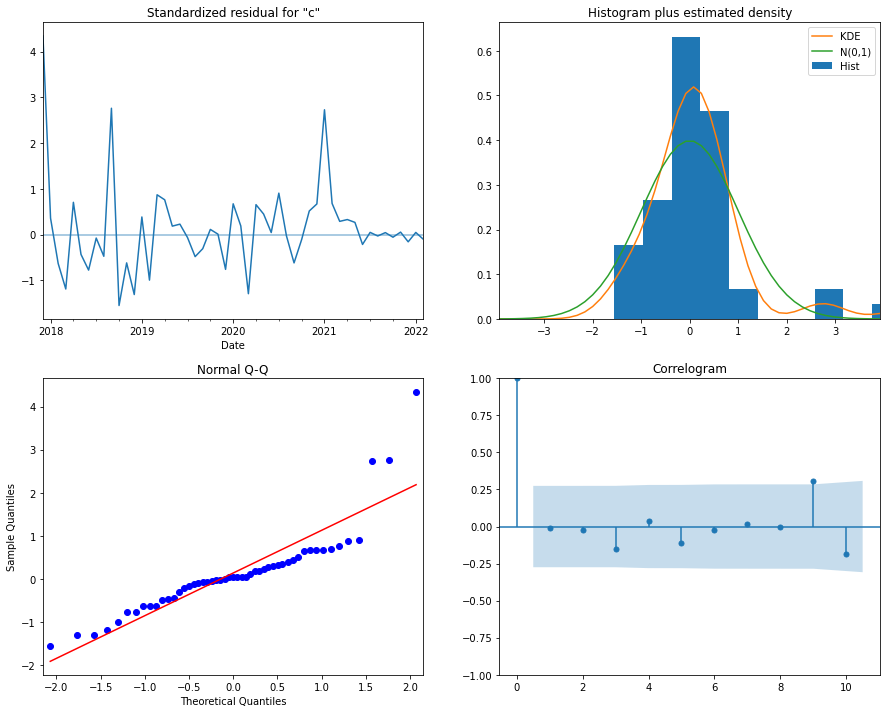

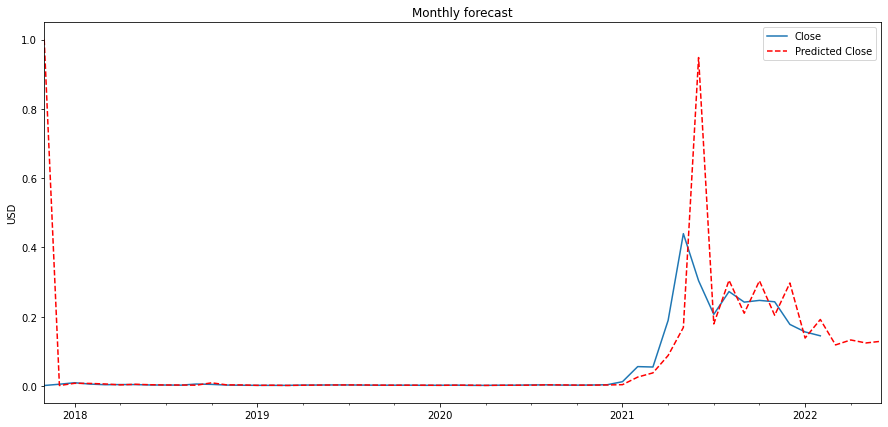

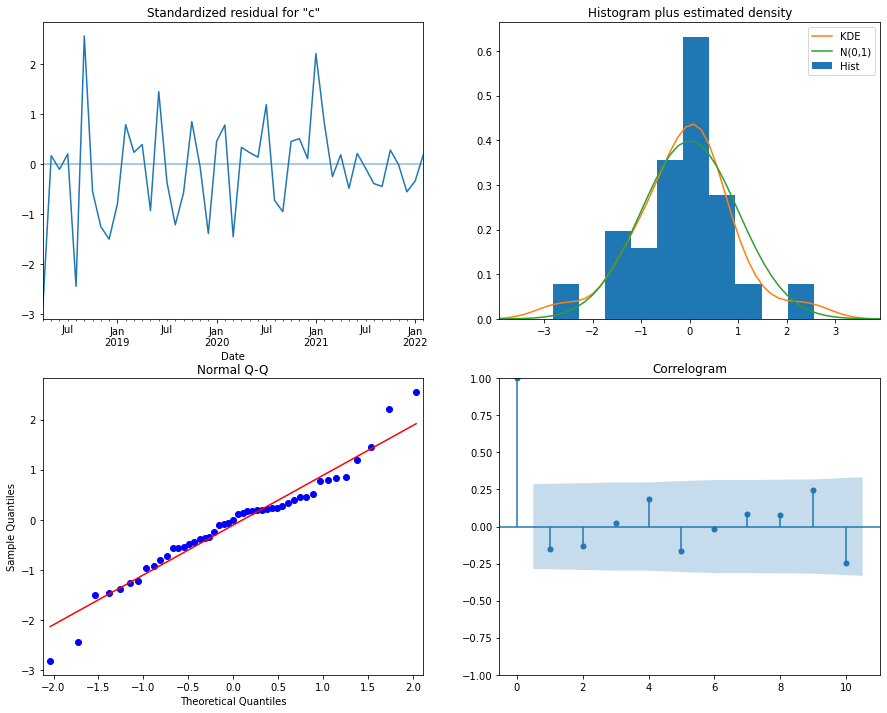

      parameters         aic
7   (0, 1, 0, 1)  345.871747
25  (1, 1, 0, 1)  346.416164
37  (2, 0, 0, 1)  347.411546
19  (1, 0, 0, 1)  347.428323
13  (0, 2, 0, 1)  347.470510
                                     SARIMAX Results                                     
Dep. Variable:                         close_box   No. Observations:                   52
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 4)   Log Likelihood                -169.936
Date:                           Mon, 23 May 2022   AIC                            345.872
Time:                                   18:17:51   BIC                            351.422
Sample:                               11-30-2017   HQIC                           347.960
                                    - 02-28-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------

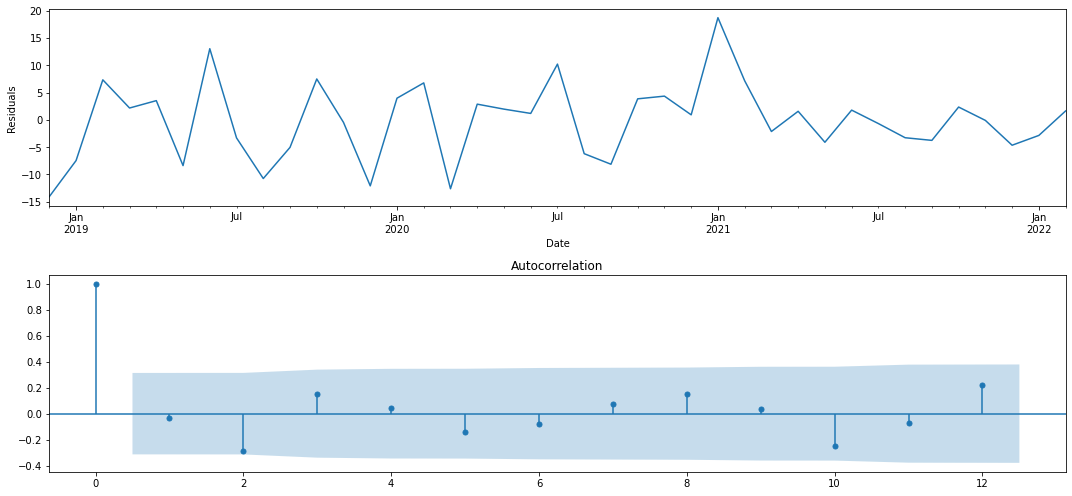

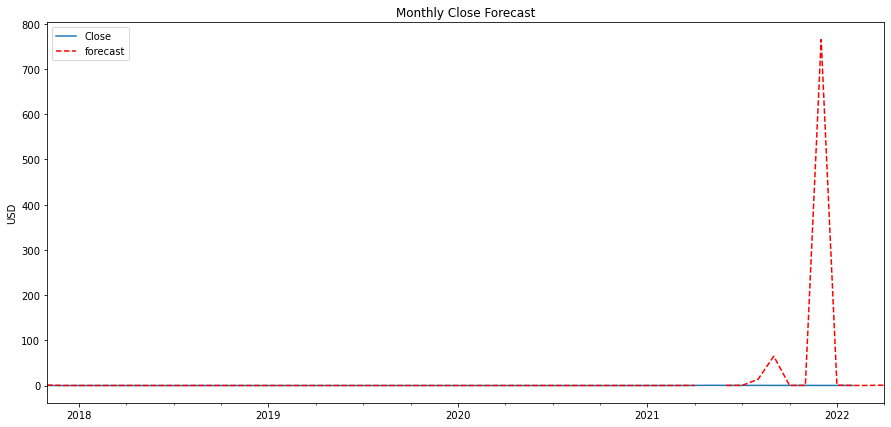

Mean Squared Error: 107.49


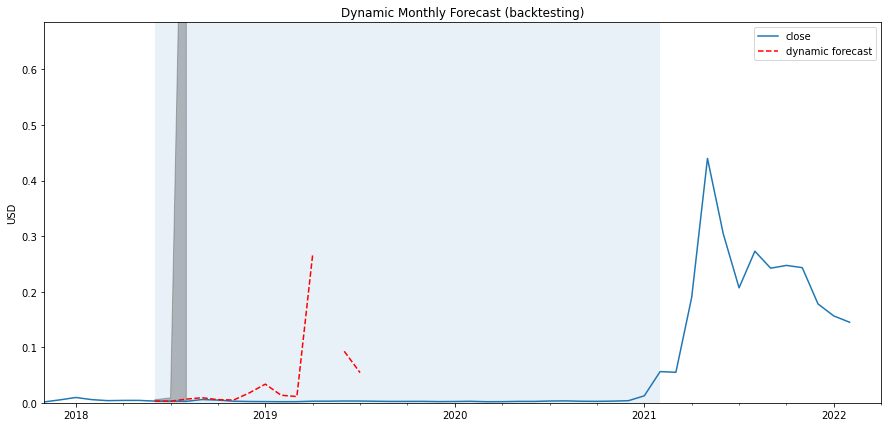

---------------------------------------------------------------------------------
ETH-USD
Dickey–Fuller test: p=0.505085


<Figure size 1080x504 with 0 Axes>

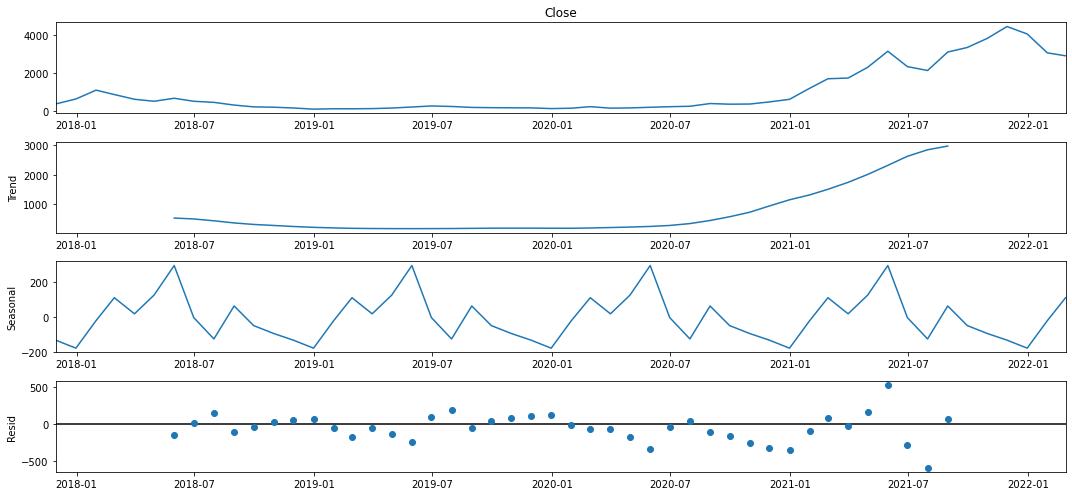

Dickey–Fuller test: p=0.675821
Dickey–Fuller test: p=0.674029
Dickey–Fuller test: p=0.057269
Dickey–Fuller test: p=0.000001


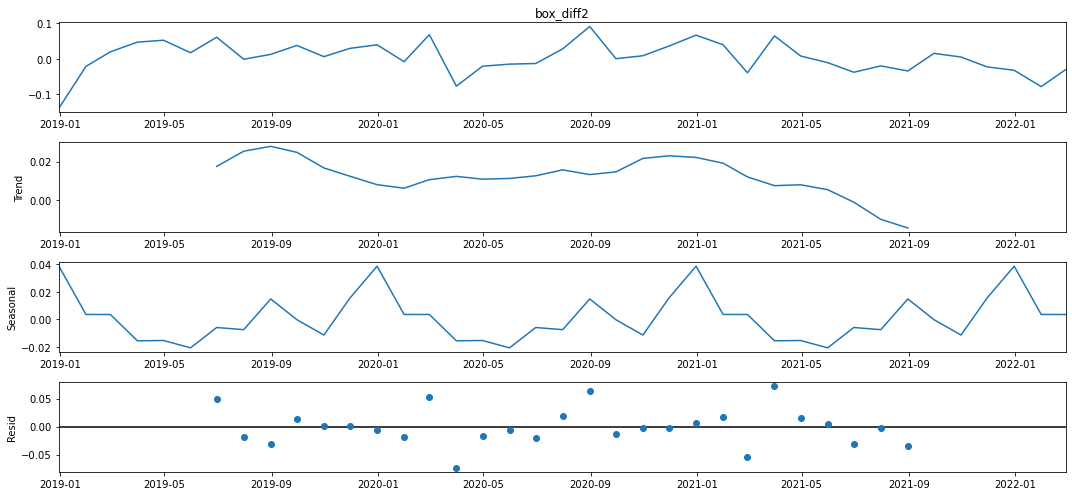

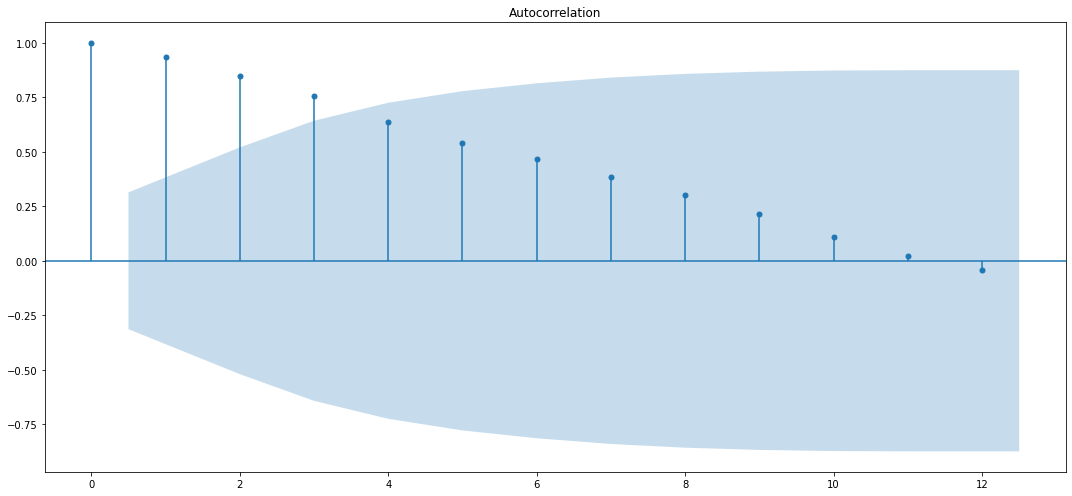

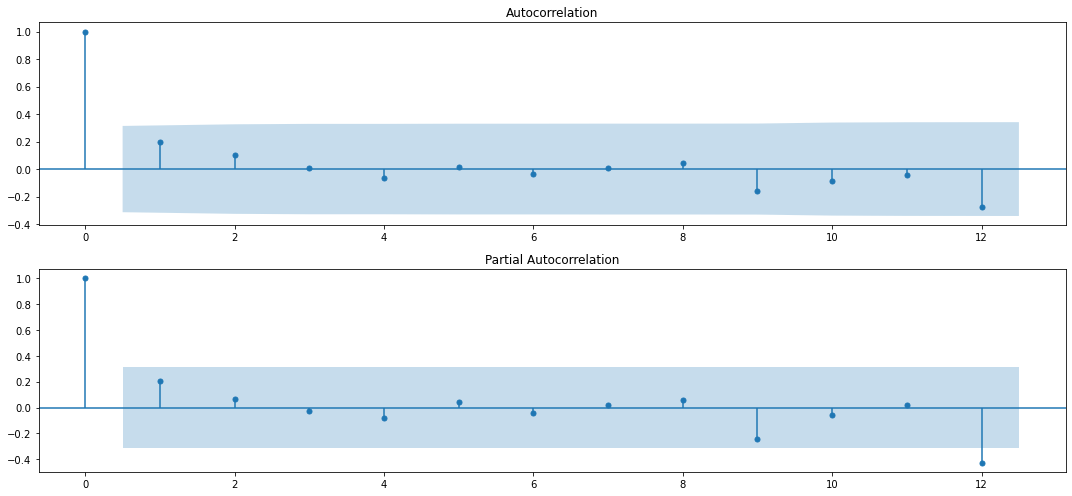

  parameters         aic
1     (0, 1) -205.305685
3     (1, 0) -204.883320
0     (0, 0) -203.924696
4     (1, 1) -203.648363
2     (0, 2) -203.512709
                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   52
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 104.653
Date:                Mon, 23 May 2022   AIC                           -205.306
Time:                        18:17:55   BIC                           -201.442
Sample:                    11-30-2017   HQIC                          -203.829
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2866      0.121      2.361      0.018      

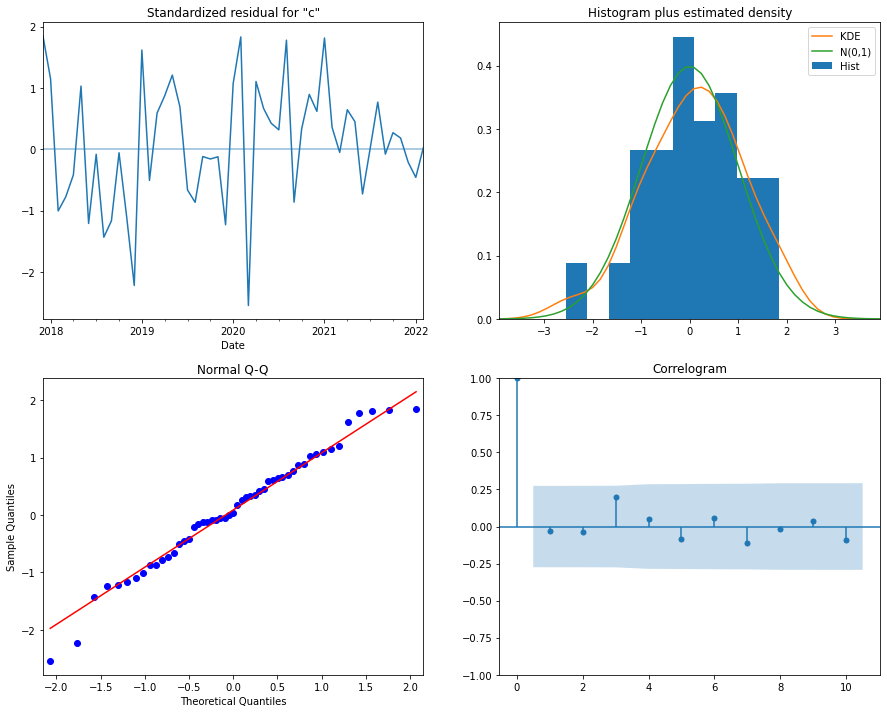

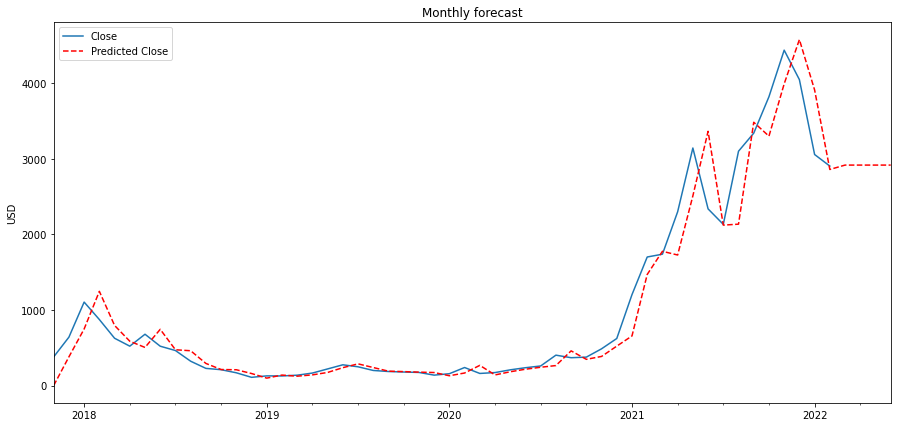

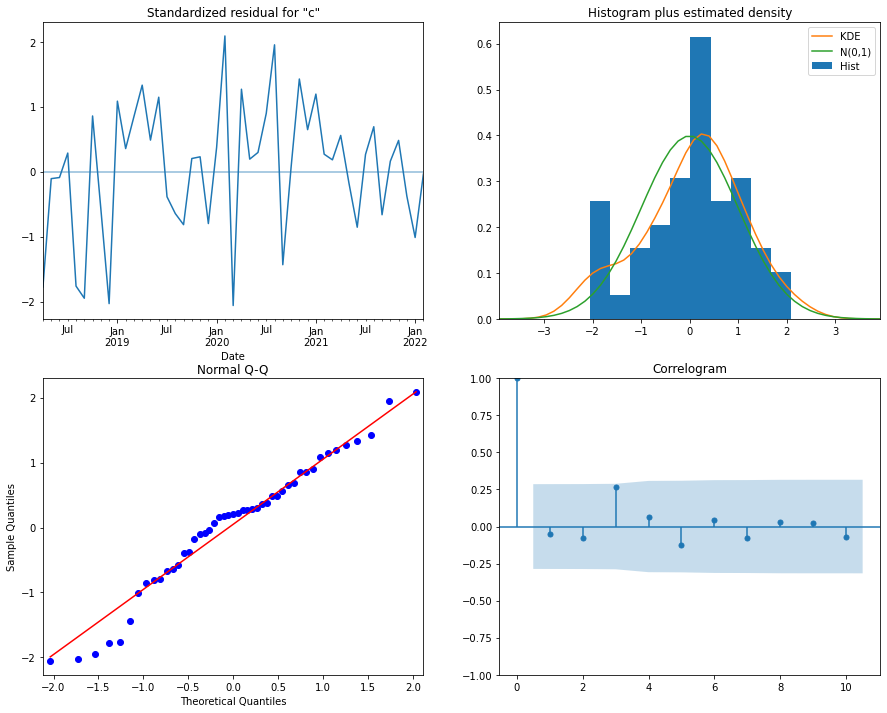

      parameters         aic
19  (1, 0, 0, 1) -176.676647
7   (0, 1, 0, 1) -176.649905
1   (0, 0, 0, 1) -175.988884
9   (0, 1, 1, 1) -174.810053
21  (1, 0, 1, 1) -174.806829
                                      SARIMAX Results                                      
Dep. Variable:                           close_box   No. Observations:                   52
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 4)   Log Likelihood                  91.338
Date:                             Mon, 23 May 2022   AIC                           -176.677
Time:                                     18:18:11   BIC                           -171.126
Sample:                                 11-30-2017   HQIC                          -174.588
                                      - 02-28-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------

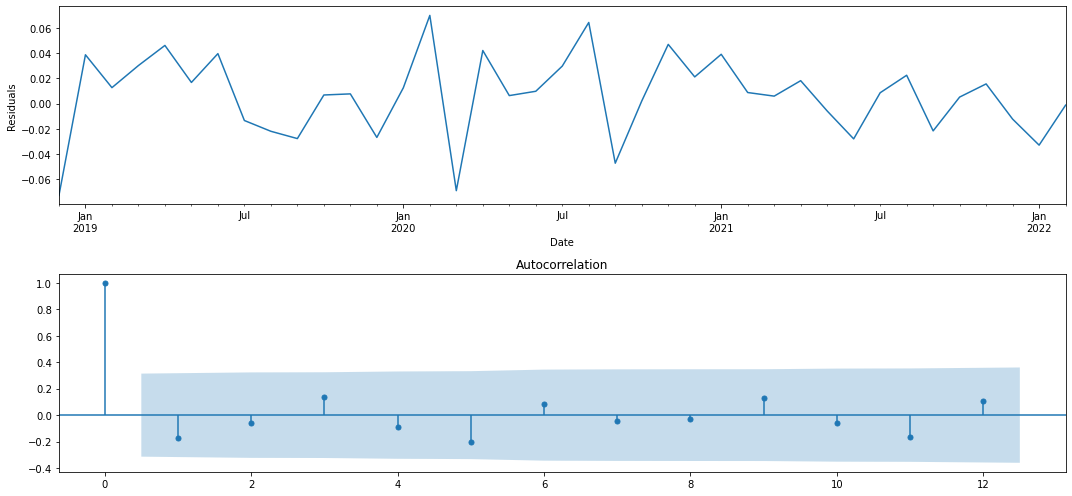

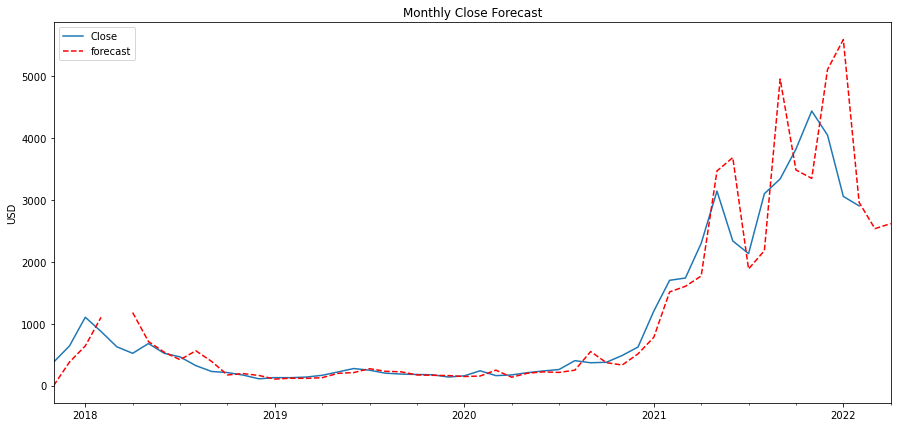

Mean Squared Error: 558.46


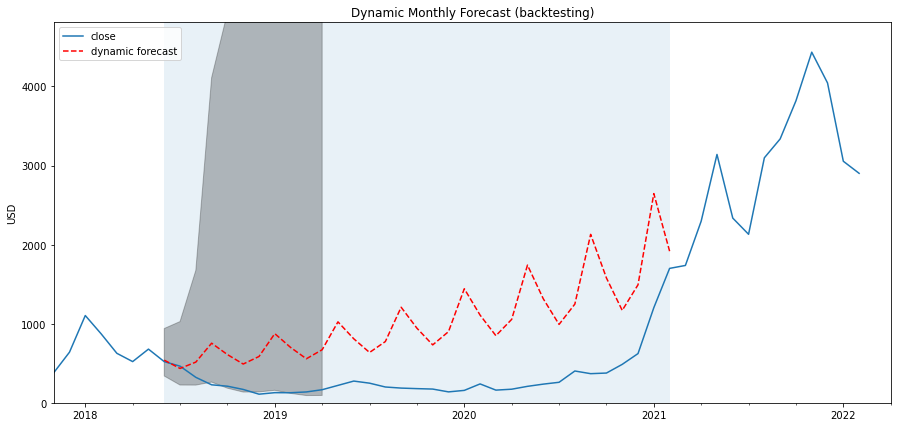

---------------------------------------------------------------------------------
HEX-USD
Dickey–Fuller test: p=0.999088


<Figure size 1080x504 with 0 Axes>

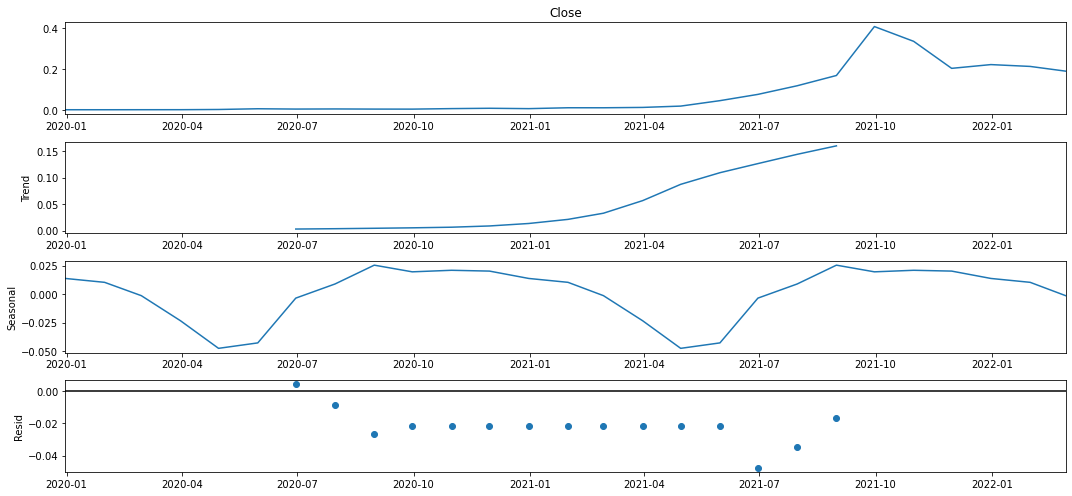

Dickey–Fuller test: p=0.626878
Dickey–Fuller test: p=0.958077
Dickey–Fuller test: p=0.035707
---------------------------------------------------------------------------------
TRX-USD
Dickey–Fuller test: p=0.106096


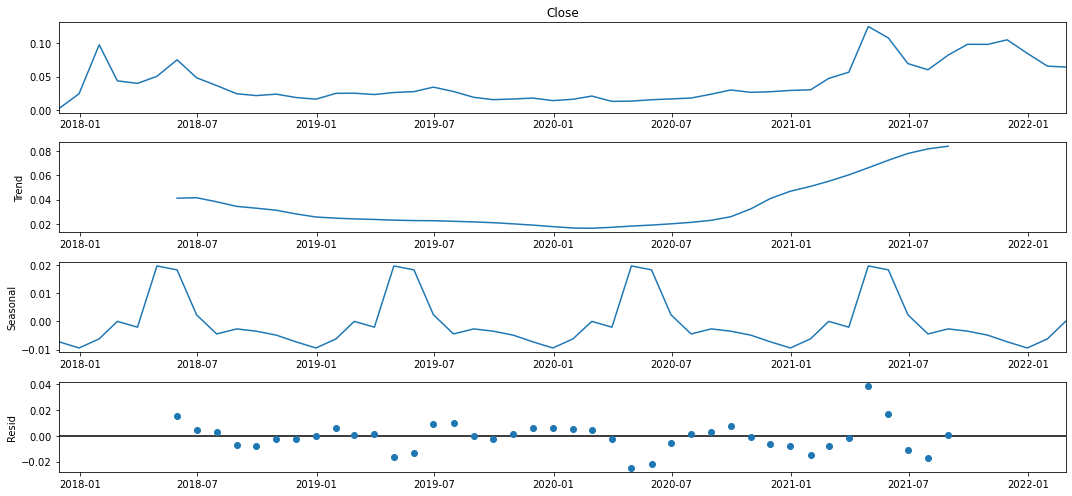

Dickey–Fuller test: p=0.009067
Dickey–Fuller test: p=0.276562
Dickey–Fuller test: p=0.000112
Dickey–Fuller test: p=0.000000


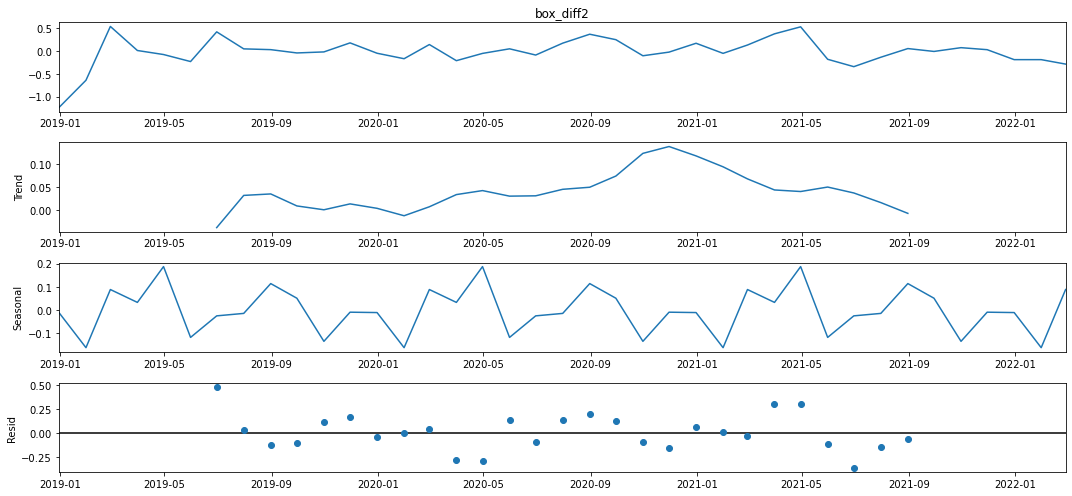

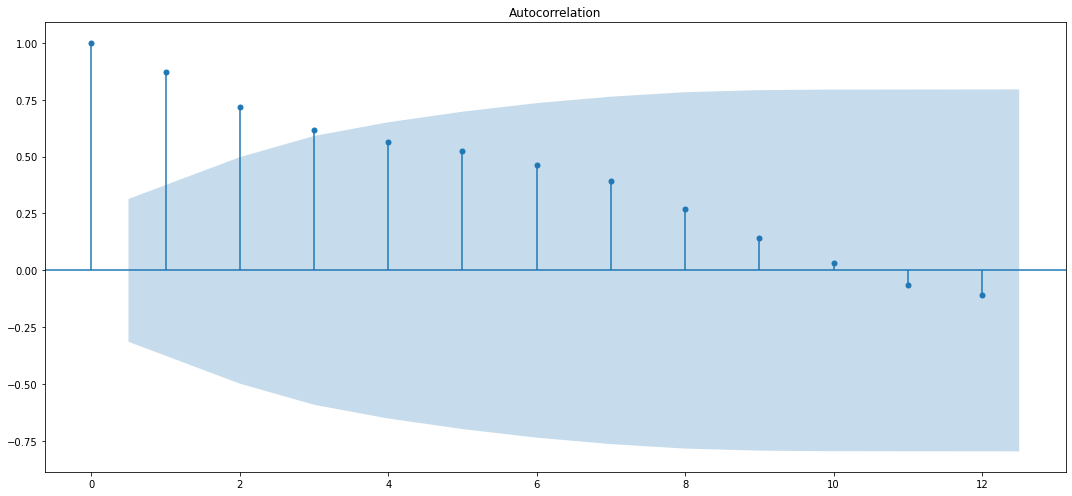

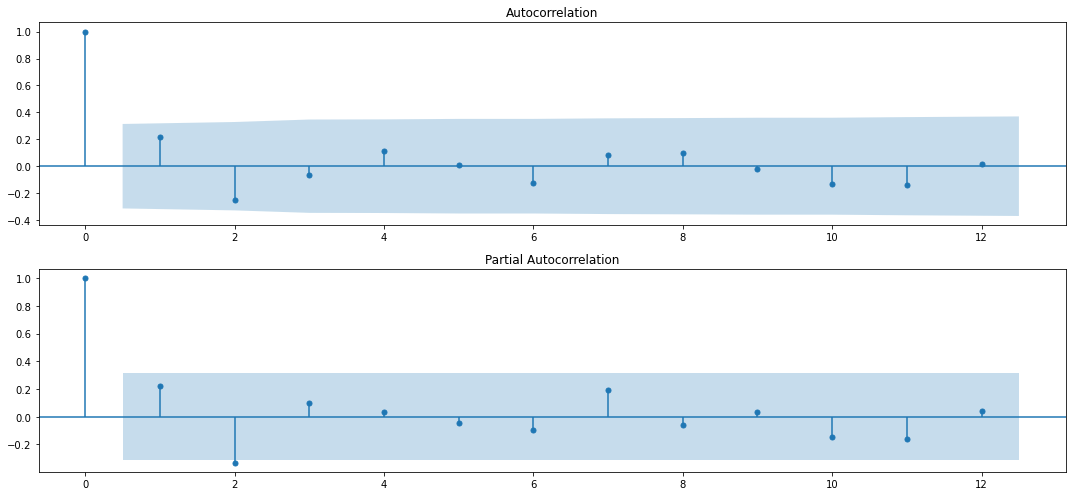

  parameters       aic
6     (2, 0)  4.481072
7     (2, 1)  6.476587
8     (2, 2)  7.094423
1     (0, 1)  7.468472
2     (0, 2)  8.278323
                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   52
Model:               SARIMAX(2, 1, 0)   Log Likelihood                   0.759
Date:                Mon, 23 May 2022   AIC                              4.481
Time:                        18:18:16   BIC                             10.277
Sample:                    11-30-2017   HQIC                             6.696
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2710      0.121      2.237      0.025       0.034      

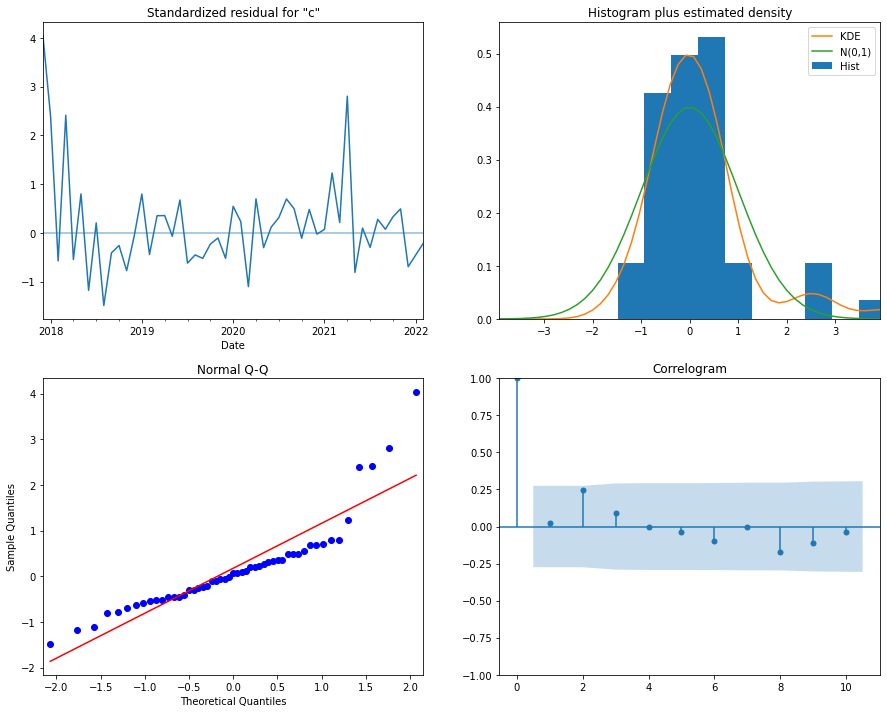

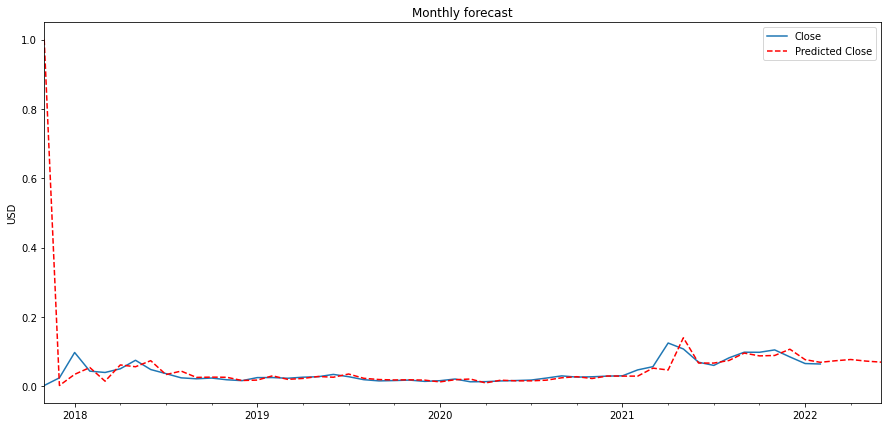

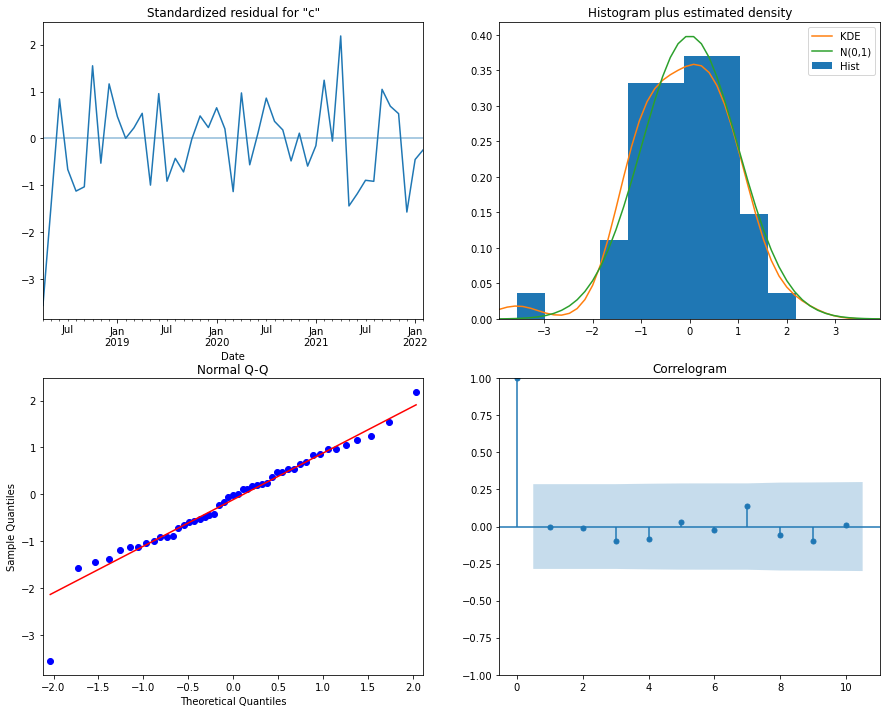

      parameters        aic
24  (1, 1, 0, 0)  13.288078
10  (0, 1, 2, 0)  13.503236
7   (0, 1, 0, 1)  13.585705
40  (2, 0, 2, 0)  13.852549
12  (0, 2, 0, 0)  14.073072
                                     SARIMAX Results                                      
Dep. Variable:                          close_box   No. Observations:                   52
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 4)   Log Likelihood                  -3.644
Date:                            Mon, 23 May 2022   AIC                             13.288
Time:                                    18:18:29   BIC                             18.839
Sample:                                11-30-2017   HQIC                            15.377
                                     - 02-28-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

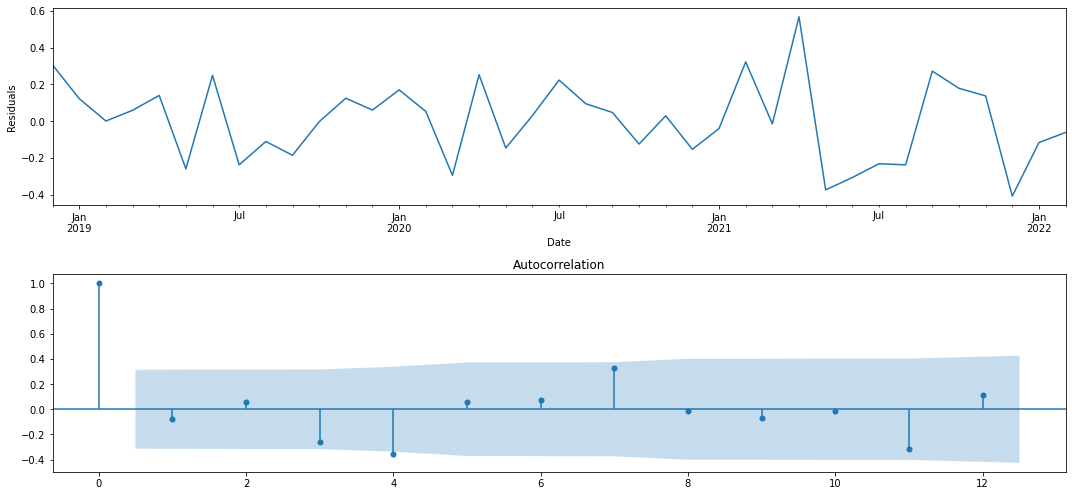

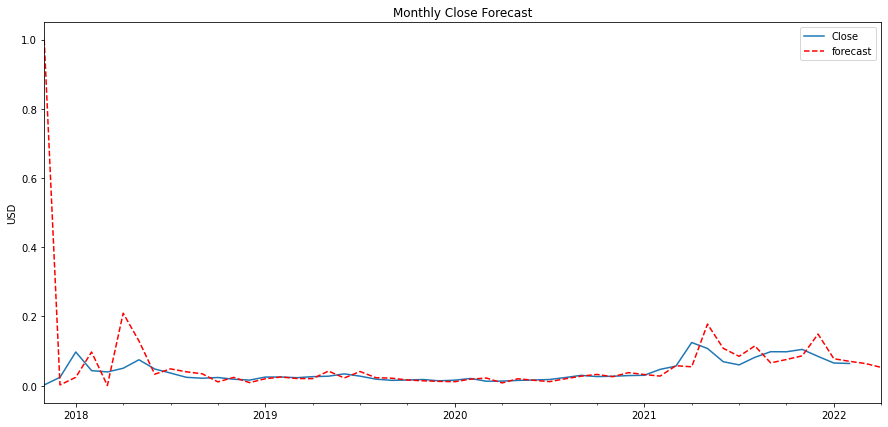

Mean Squared Error: 0.14


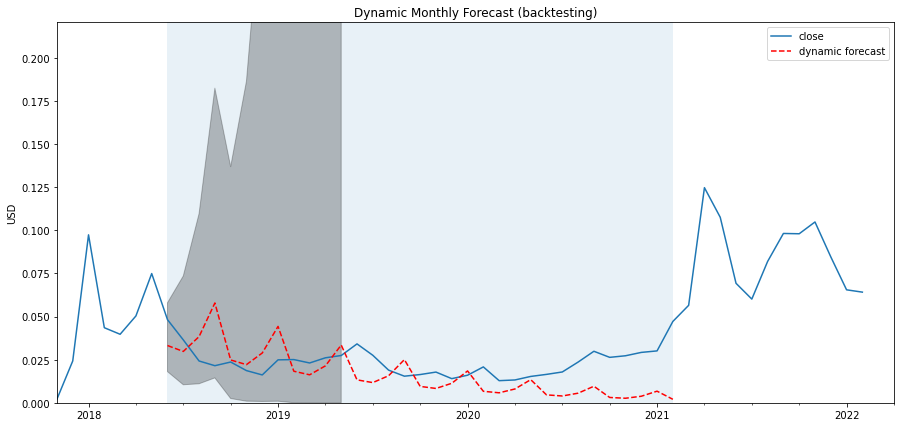

---------------------------------------------------------------------------------
USDC-USD
Dickey–Fuller test: p=0.154542


<Figure size 1080x504 with 0 Axes>

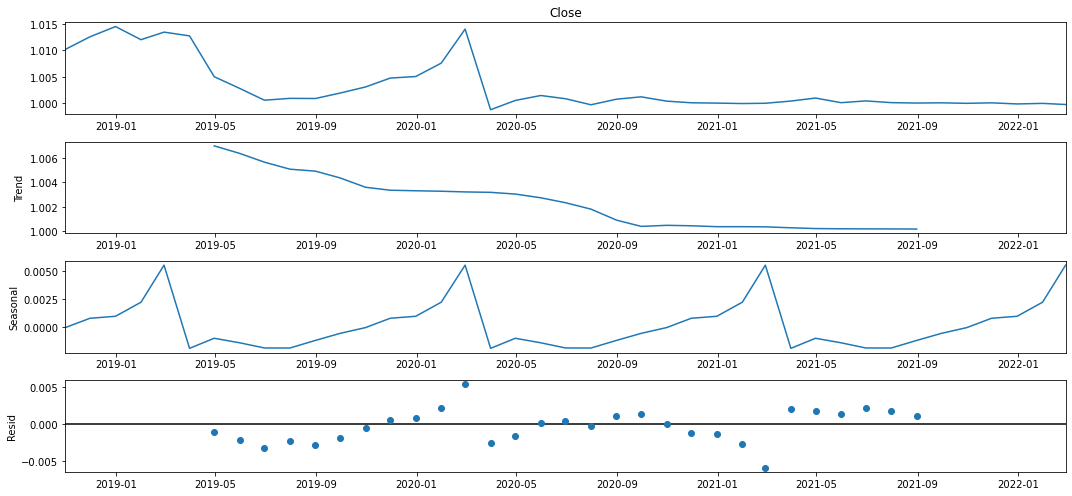

Dickey–Fuller test: p=0.132244
Dickey–Fuller test: p=0.003407
Dickey–Fuller test: p=0.000007
Dickey–Fuller test: p=0.000002


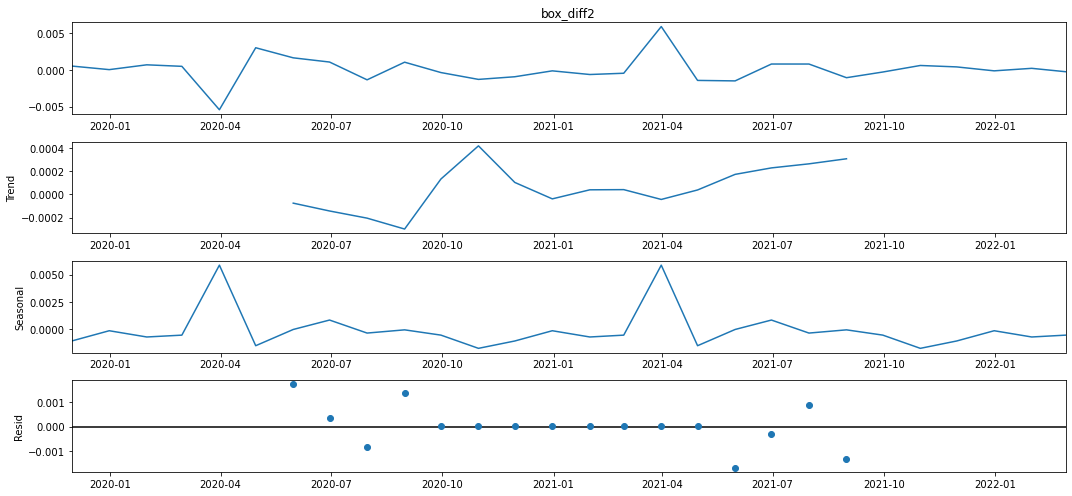

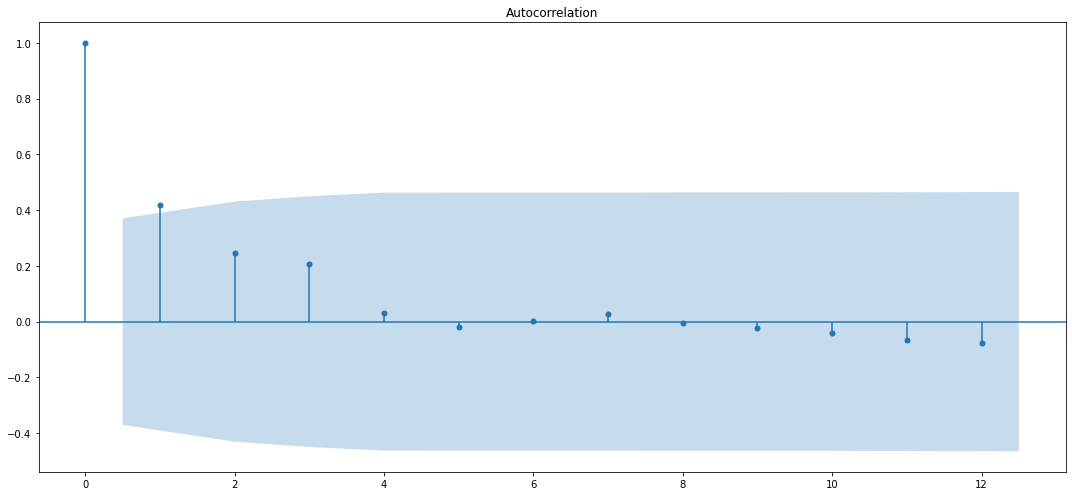

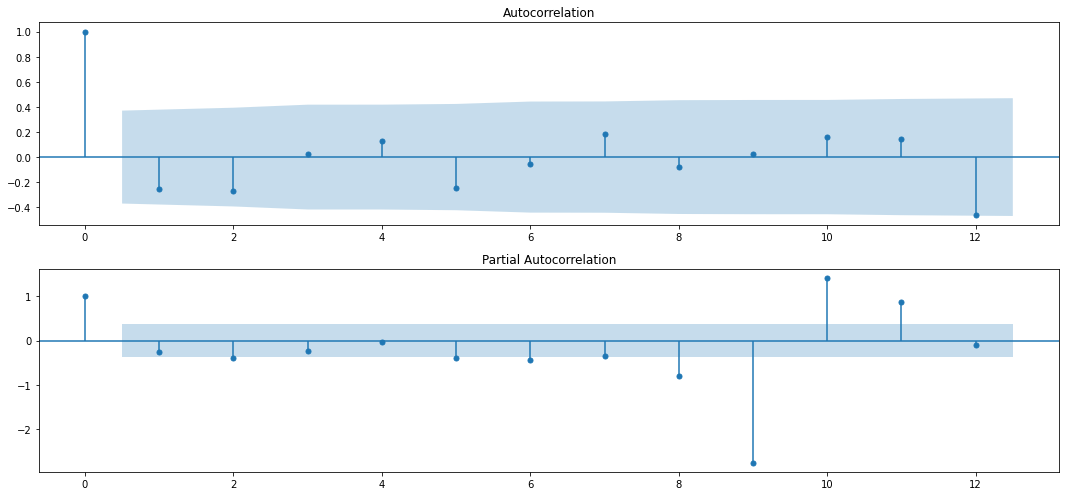

  parameters         aic
1     (0, 1) -433.877131
4     (1, 1) -432.999998
3     (1, 0) -432.854993
2     (0, 2) -432.844291
0     (0, 0) -432.829304
                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   41
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 218.939
Date:                Mon, 23 May 2022   AIC                           -433.877
Time:                        18:18:33   BIC                           -430.499
Sample:                    10-31-2018   HQIC                          -432.656
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2836      0.223     -1.271      0.204      

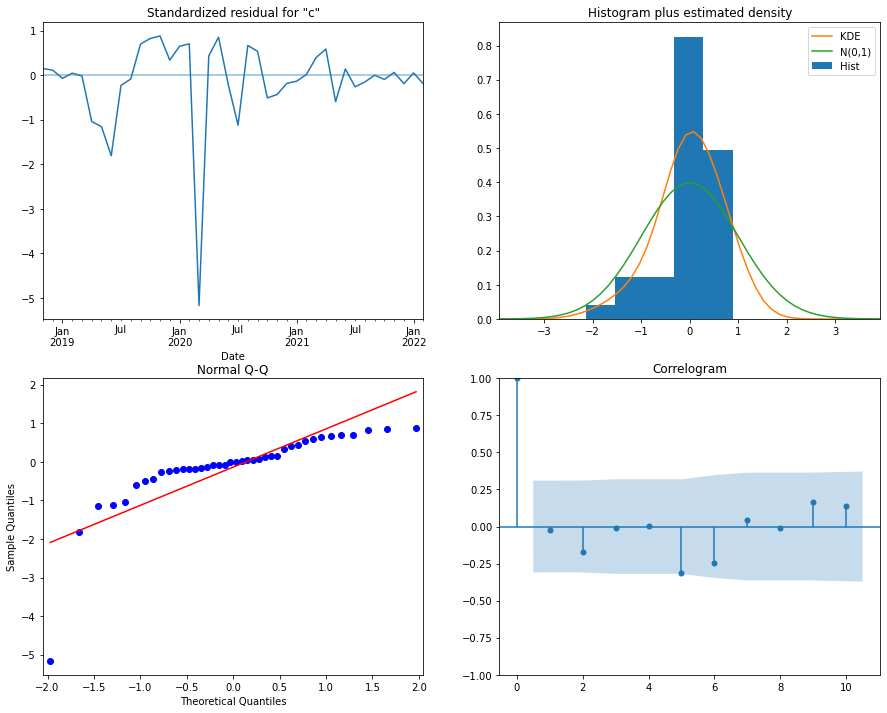

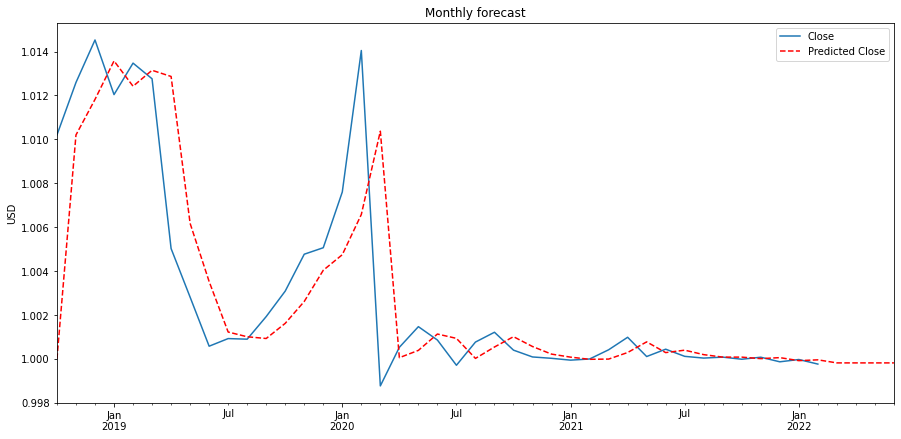

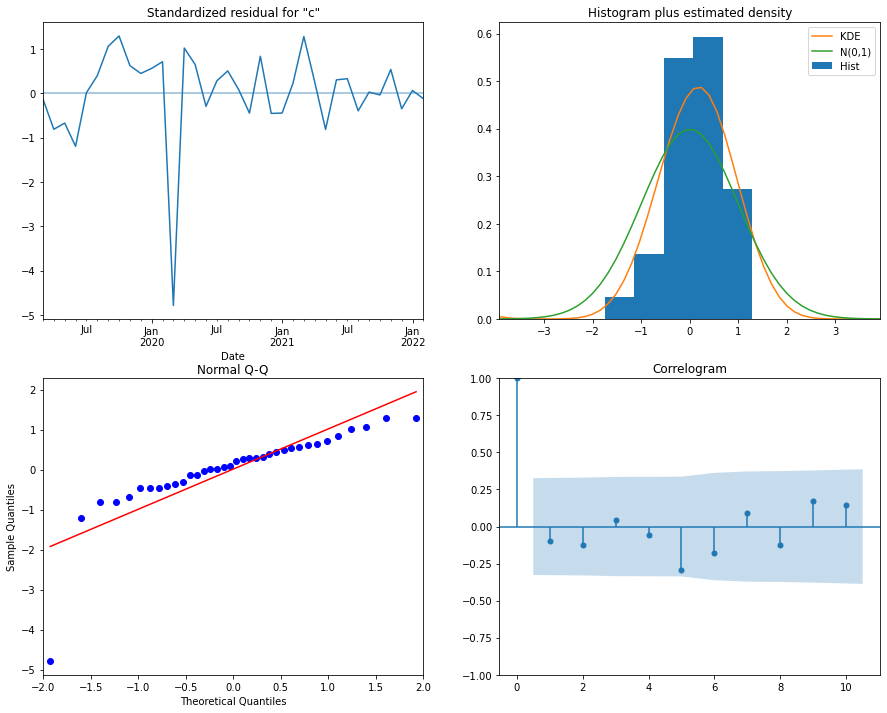

      parameters         aic
7   (0, 1, 0, 1) -375.671819
1   (0, 0, 0, 1) -375.620610
19  (1, 0, 0, 1) -375.305841
13  (0, 2, 0, 1) -375.039952
31  (1, 2, 0, 1) -373.808245
                                     SARIMAX Results                                     
Dep. Variable:                         close_box   No. Observations:                   41
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 4)   Log Likelihood                 190.836
Date:                           Mon, 23 May 2022   AIC                           -375.672
Time:                                   18:18:43   BIC                           -370.921
Sample:                               10-31-2018   HQIC                          -374.014
                                    - 02-28-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------

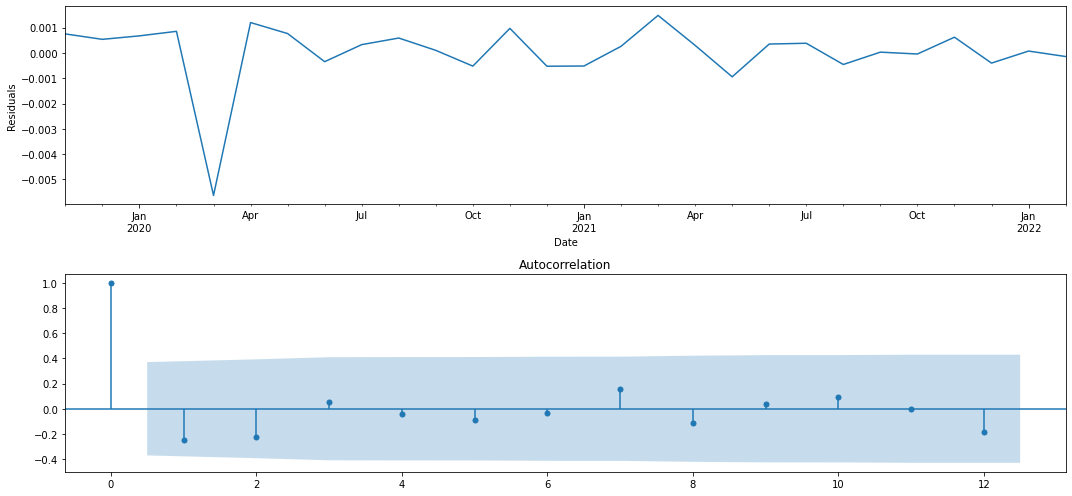

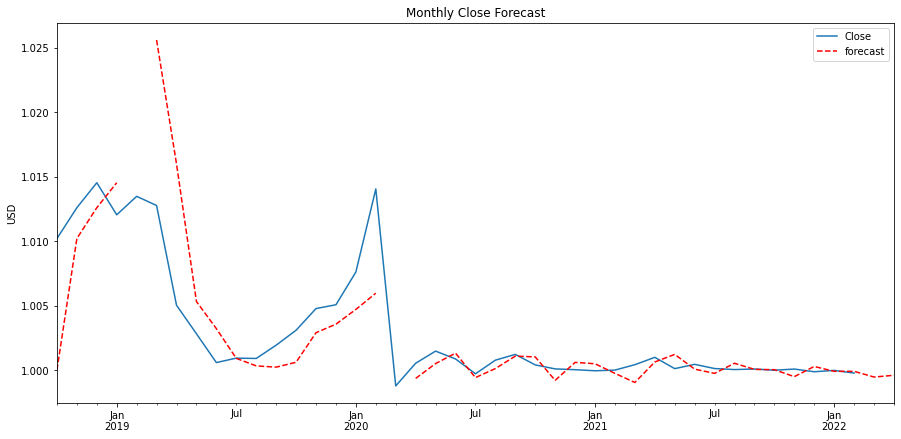

Mean Squared Error: 0.0
---------------------------------------------------------------------------------
XRP-USD
Dickey–Fuller test: p=0.067031


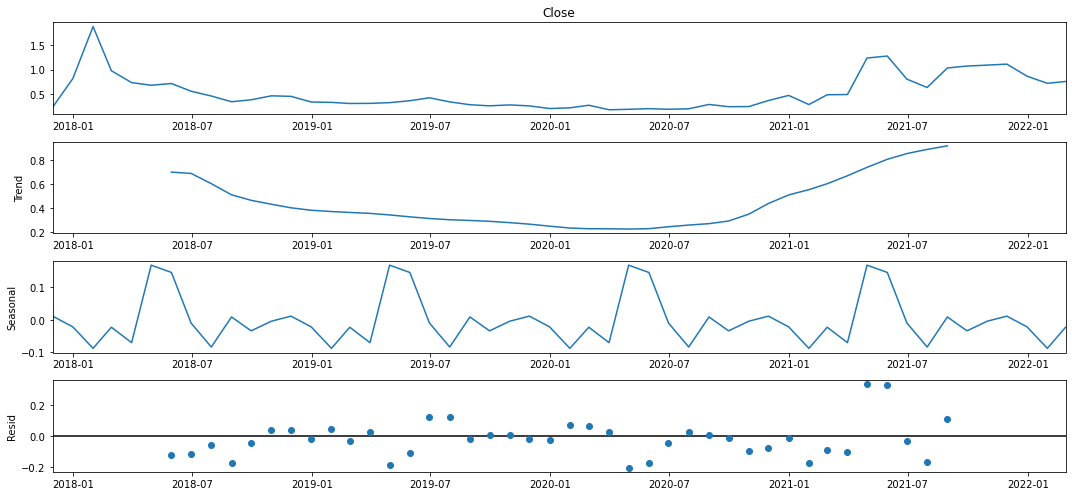

Dickey–Fuller test: p=0.264865
Dickey–Fuller test: p=0.486017
Dickey–Fuller test: p=0.169174
Dickey–Fuller test: p=0.000000


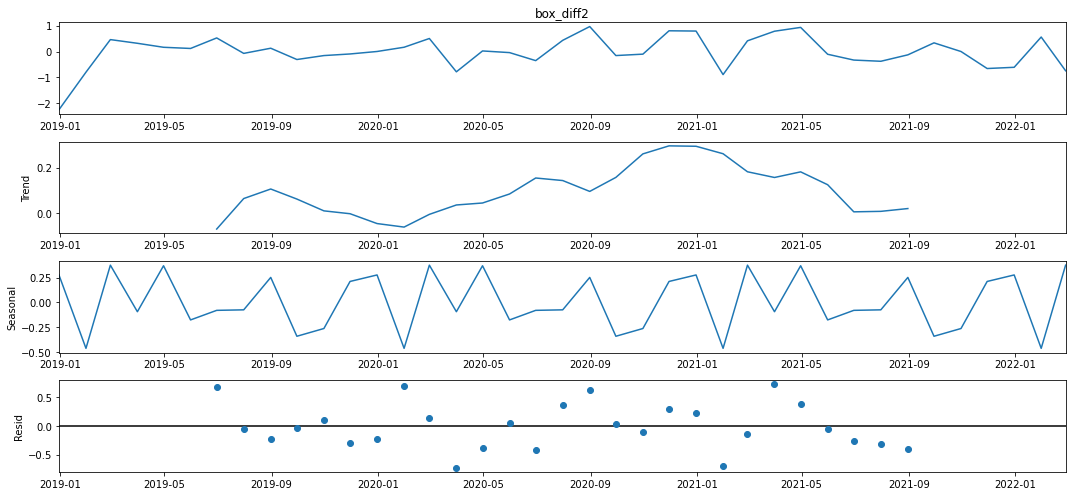

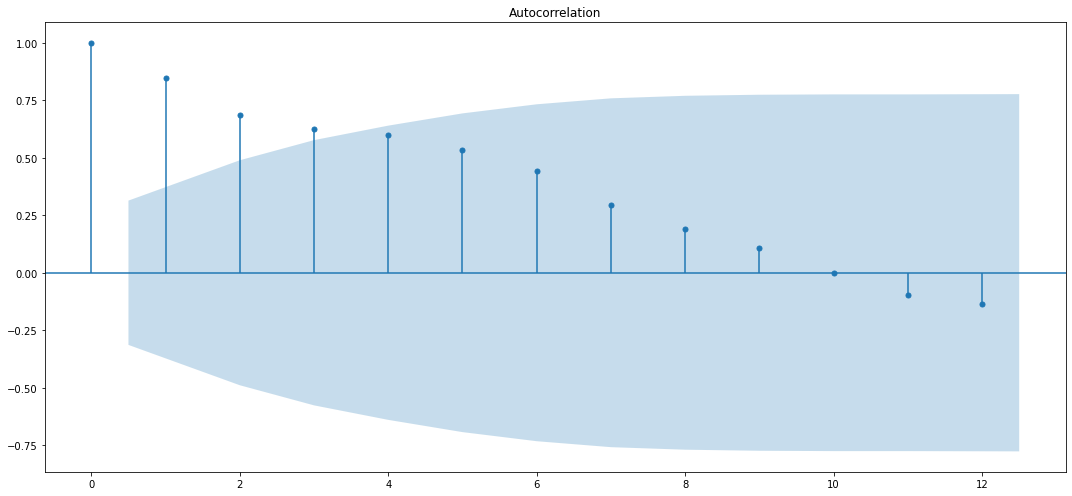

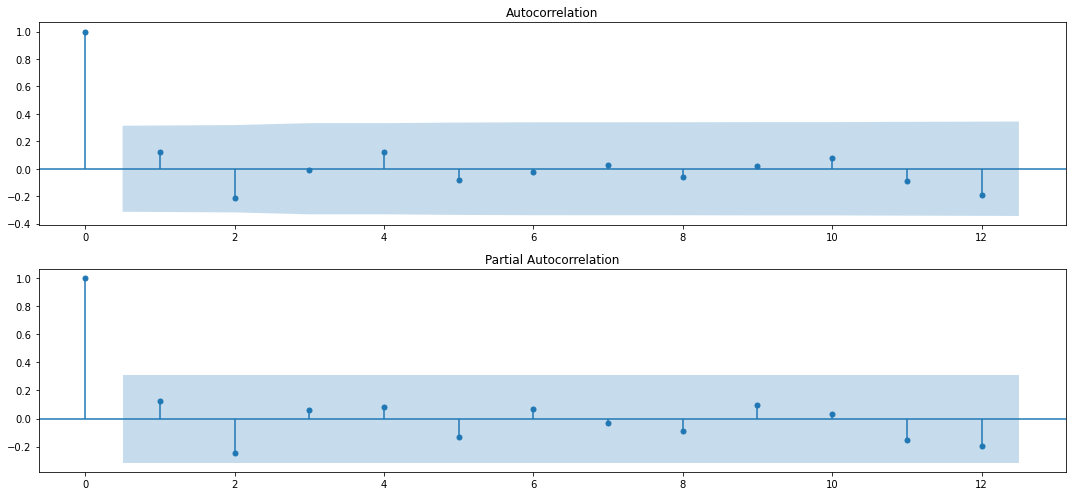

  parameters        aic
0     (0, 0)  65.527071
6     (2, 0)  65.648313
2     (0, 2)  66.833159
1     (0, 1)  67.314145
3     (1, 0)  67.435791
                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   52
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -31.764
Date:                Mon, 23 May 2022   AIC                             65.527
Time:                        18:18:47   BIC                             67.459
Sample:                    11-30-2017   HQIC                            66.265
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.2035      0.024      8.579      0.000       0.157

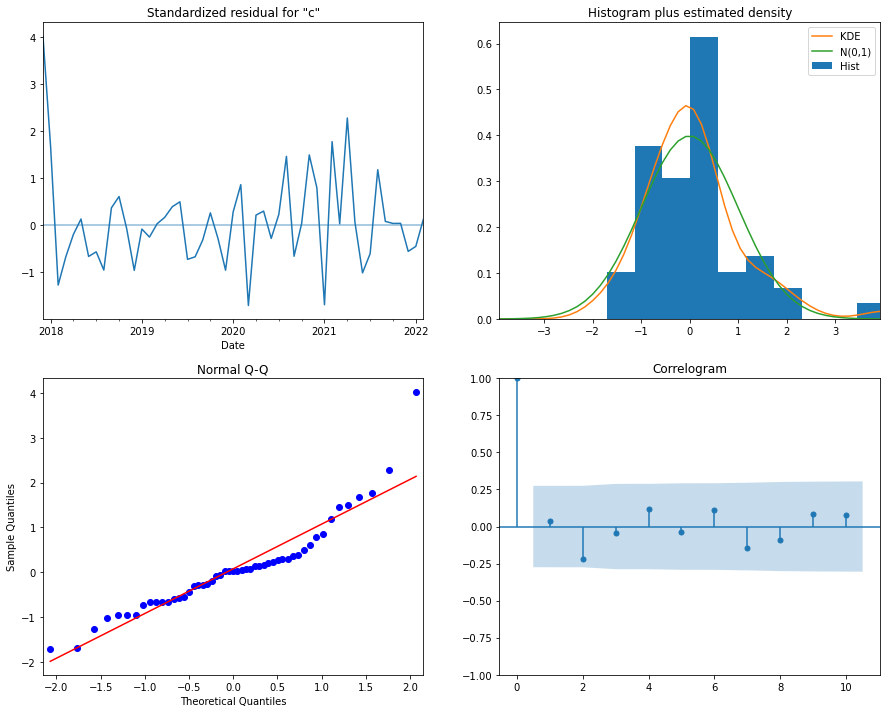

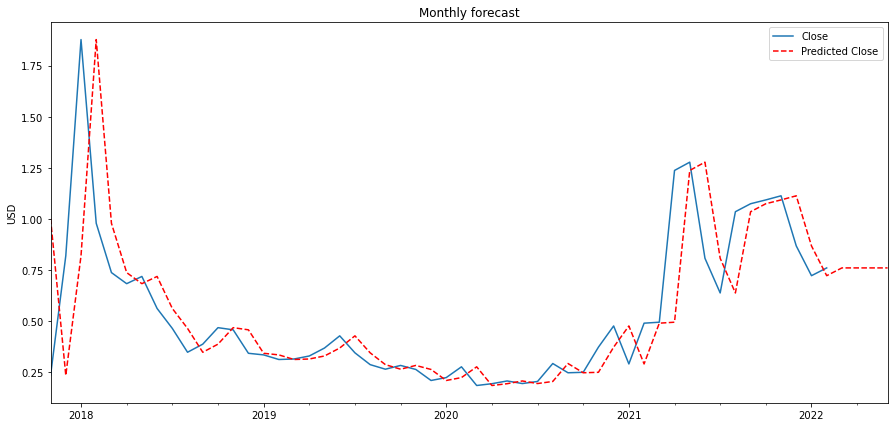

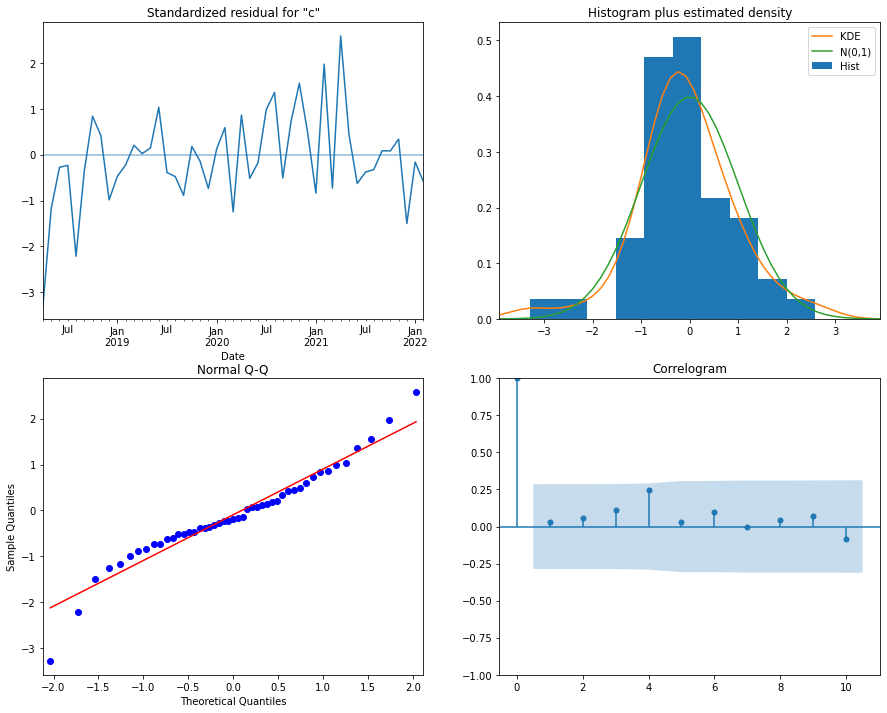

      parameters        aic
37  (2, 0, 0, 1)  71.633615
39  (2, 0, 1, 1)  71.991669
15  (0, 2, 1, 1)  72.046340
13  (0, 2, 0, 1)  72.963700
3   (0, 0, 1, 1)  73.153757
                                      SARIMAX Results                                      
Dep. Variable:                           close_box   No. Observations:                   52
Model:             SARIMAX(2, 1, 0)x(0, 1, [1], 4)   Log Likelihood                 -31.817
Date:                             Mon, 23 May 2022   AIC                             71.634
Time:                                     18:18:59   BIC                             79.034
Sample:                                 11-30-2017   HQIC                            74.419
                                      - 02-28-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------

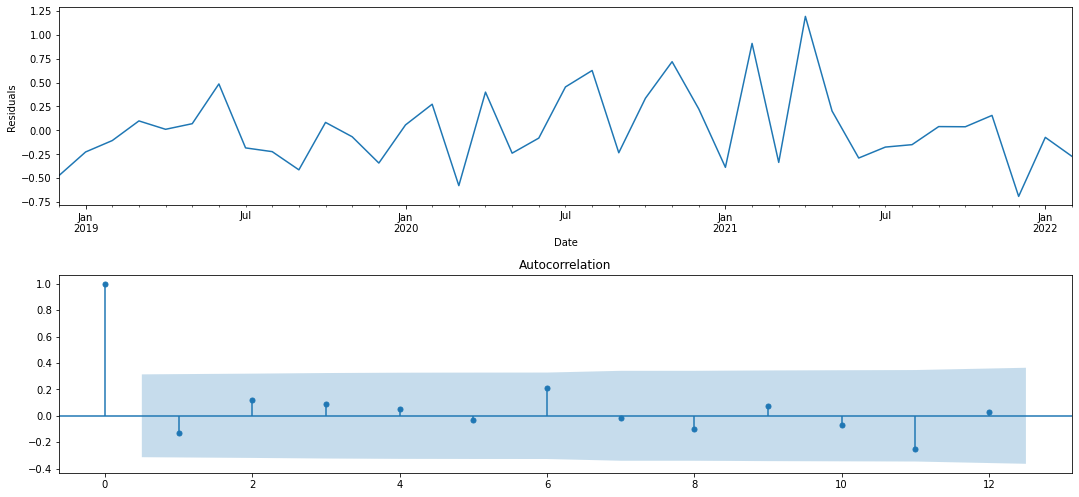

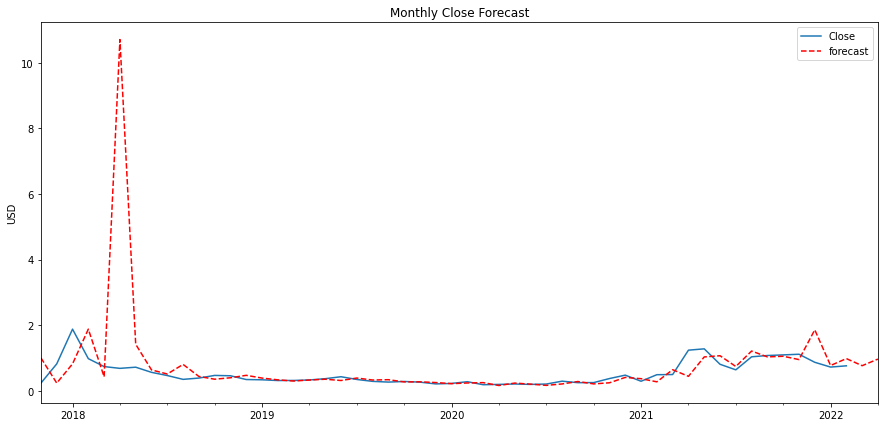

Mean Squared Error: 1.43


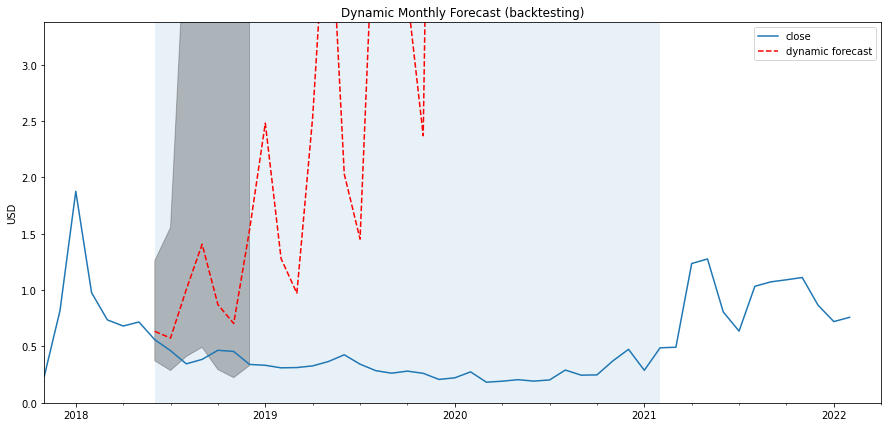

<Figure size 1080x504 with 0 Axes>

In [36]:
for i in z:
  try:
    model(i)
  except:
    pass

In [ ]:
result_table

parameters         aic
0   (0, 0, 0, 0)  106.241926
1   (0, 0, 0, 1)   59.367165
2   (0, 0, 1, 0)   83.566593
3   (0, 0, 1, 1)   61.308776
4   (0, 0, 2, 0)   80.581268
5   (0, 0, 2, 1)   63.301881
6   (0, 1, 0, 0)   93.848455
7   (0, 1, 0, 1)   49.141926
8   (0, 1, 1, 0)   75.962699
9   (0, 1, 1, 1)   51.136808
10  (0, 1, 2, 0)   69.932768
11  (0, 1, 2, 1)   52.860540
12  (0, 2, 0, 0)   95.768507
13  (0, 2, 0, 1)   50.895717
14  (0, 2, 1, 0)   77.810854
15  (0, 2, 1, 1)   52.895573
16  (0, 2, 2, 0)   71.061504
17  (0, 2, 2, 1)   54.607841
18  (1, 0, 0, 0)   95.040787
19  (1, 0, 0, 1)   49.103200
20  (1, 0, 1, 0)   75.649676
21  (1, 0, 1, 1)   51.099634
22  (1, 0, 2, 0)   68.654439
23  (1, 0, 2, 1)   52.947022
24  (1, 1, 0, 0)   88.578636
25  (1, 1, 0, 1)   50.802037
26  (1, 1, 1, 0)   77.610554
27  (1, 1, 1, 1)   52.800821
28  (1, 1, 2, 0)   70.626912
29  (1, 1, 2, 1)   54.533003
30  (1, 2, 0, 0)   89.703492
31  (1, 2, 0, 1)   52.664873
32  (1, 2, 1, 0)   79.578056
33  (1, 2, 1, 1)   54.660445
34  (1, 2, 2, 0)   72.619449
35  (1, 2, 2, 1)   56.428797
36  (2, 0, 0, 0)   95.793009
37  (2, 0, 0, 1)   50.913455
38  (2, 0, 1, 0)   77.617077
39  (2, 0, 1, 1)   52.913517
40  (2, 0, 2, 0)   70.628383
41  (2, 0, 2, 1)   54.678274
42  (2, 1, 0, 0)   87.834804
43  (2, 1, 0, 1)   52.687137
44  (2, 1, 1, 0)   73.313451
45  (2, 1, 1, 1)   54.675093
46  (2, 1, 2, 0)   68.579255
47  (2, 1, 2, 1)   56.442052
48  (2, 2, 0, 0)   82.885716
49  (2, 2, 0, 1)   53.821320
50  (2, 2, 1, 0)   75.772351
51  (2, 2, 1, 1)   56.599708
52  (2, 2, 2, 0)   72.671671
53  (2, 2, 2, 1)   57.604878

In [ ]:
best_model.llf

-15.495952571133921

---------------------------------------------------------------------------------
TRX-USD
Dickey–Fuller test: p=0.106096


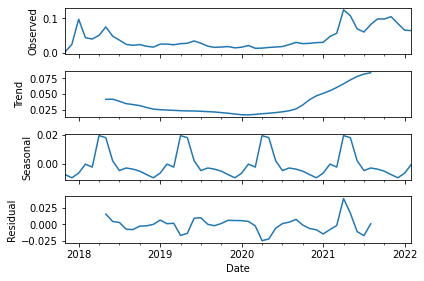

Dickey–Fuller test: p=0.009067
Dickey–Fuller test: p=0.276562
Dickey–Fuller test: p=0.000112
Dickey–Fuller test: p=0.000000


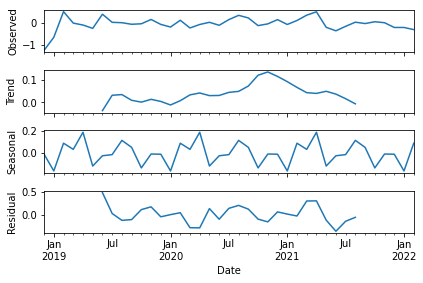

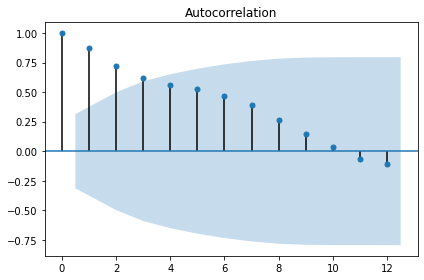

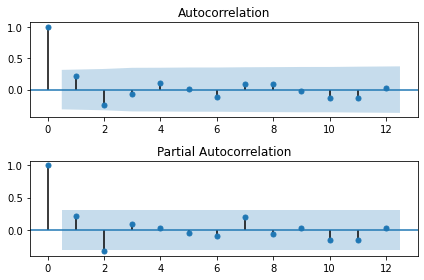

  parameters       aic
6     (2, 0)  4.481072
7     (2, 1)  6.476587
8     (2, 2)  7.094423
1     (0, 1)  7.468472
2     (0, 2)  8.278323
                           Statespace Model Results                           
Dep. Variable:              close_box   No. Observations:                   52
Model:               SARIMAX(2, 1, 0)   Log Likelihood                   0.759
Date:                Sun, 22 May 2022   AIC                              4.481
Time:                        10:44:27   BIC                             10.277
Sample:                    11-30-2017   HQIC                             6.696
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2710      0.121      2.237      0.025       0.034      

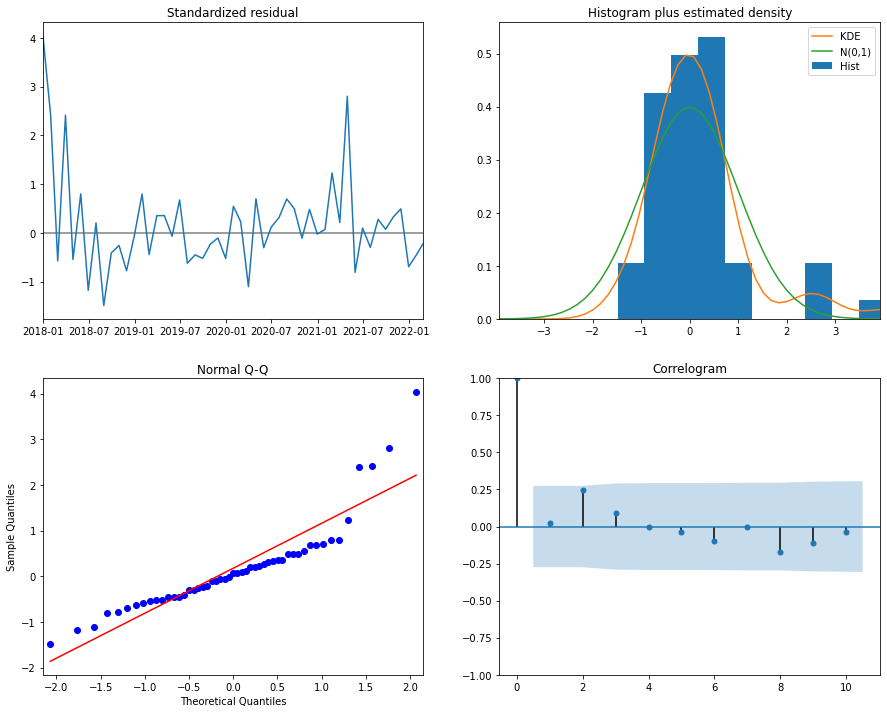

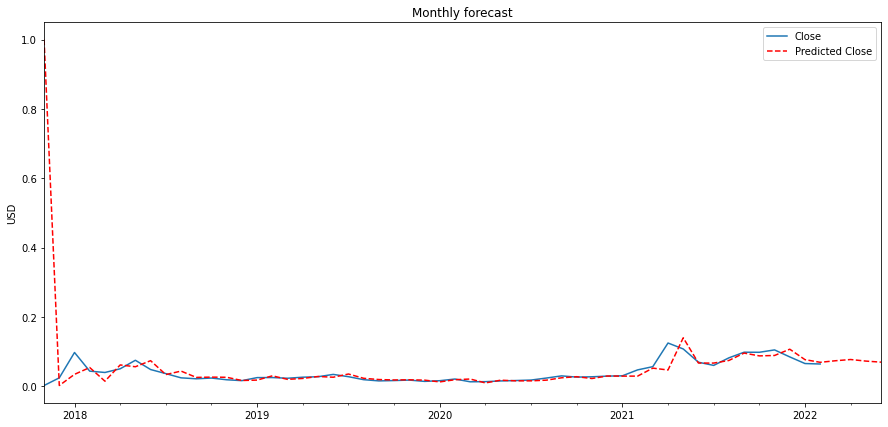

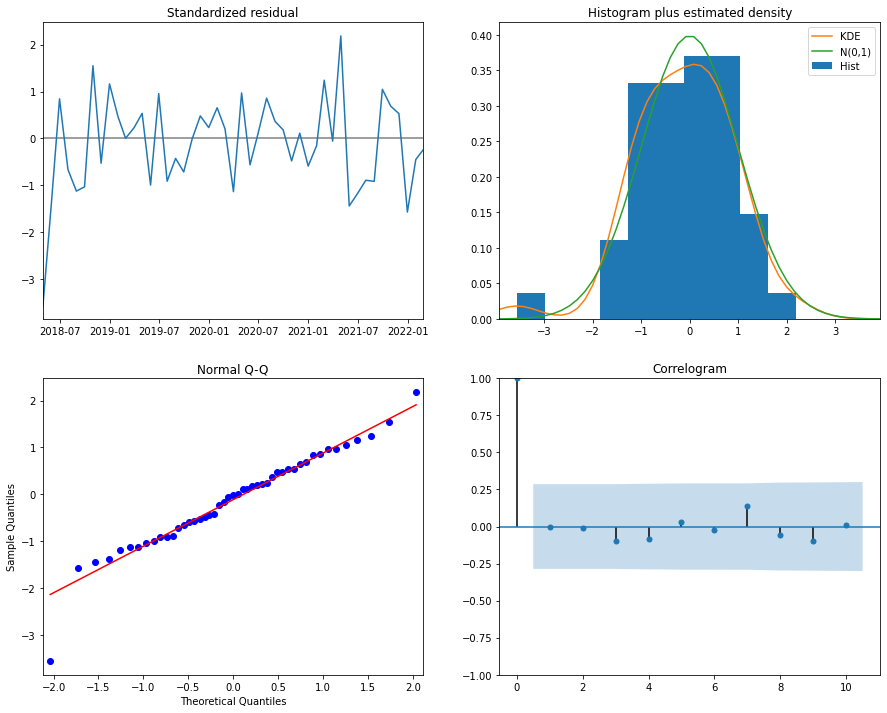

      parameters        aic
24  (1, 1, 0, 0)  13.288078
10  (0, 1, 2, 0)  13.503237
7   (0, 1, 0, 1)  13.585705
40  (2, 0, 2, 0)  13.852549
12  (0, 2, 0, 0)  14.073072
                                 Statespace Model Results                                
Dep. Variable:                         close_box   No. Observations:                   52
Model:             SARIMAX(1, 1, 1)x(0, 1, 0, 4)   Log Likelihood                  -3.644
Date:                           Sun, 22 May 2022   AIC                             13.288
Time:                                   10:44:44   BIC                             18.839
Sample:                               11-30-2017   HQIC                            15.377
                                    - 02-28-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------

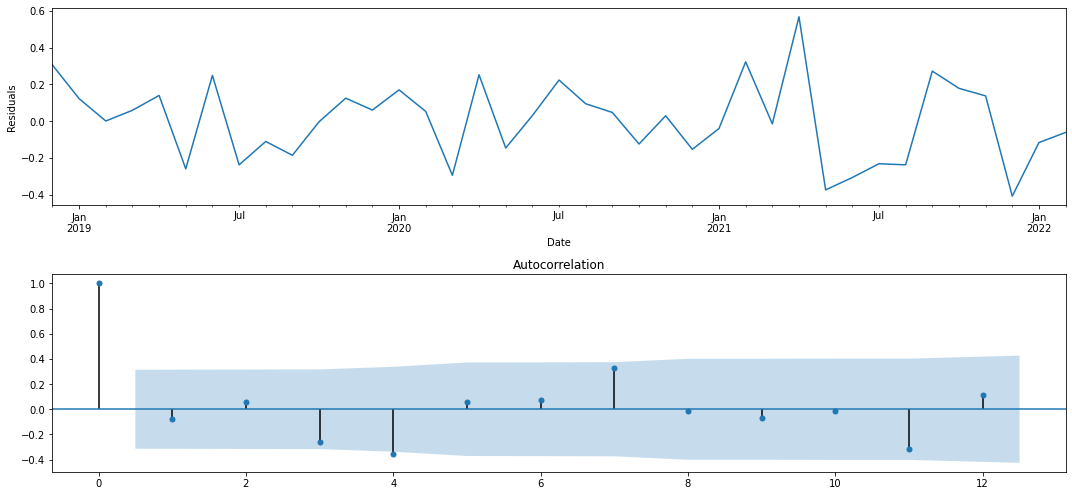

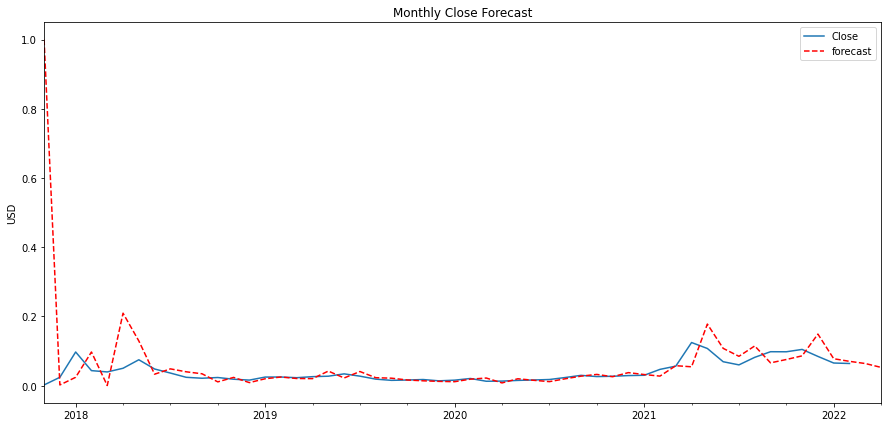

Mean Squared Error: 0.14


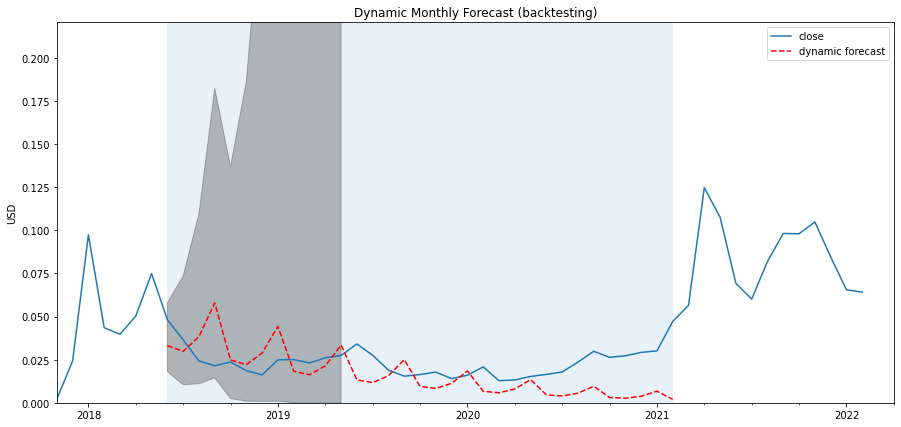

<Figure size 432x288 with 0 Axes>

In [ ]:
model('DAI-USD')

In [ ]:
AIC

[34.99190514226784]

In [ ]:
result_table

parameters         aic
0   (0, 0, 0, 0)  106.241926
1   (0, 0, 0, 1)   59.367165
2   (0, 0, 1, 0)   83.566593
3   (0, 0, 1, 1)   61.308776
4   (0, 0, 2, 0)   80.581268
5   (0, 0, 2, 1)   63.301881
6   (0, 1, 0, 0)   93.848455
7   (0, 1, 0, 1)   49.141926
8   (0, 1, 1, 0)   75.962699
9   (0, 1, 1, 1)   51.136808
10  (0, 1, 2, 0)   69.932768
11  (0, 1, 2, 1)   52.860540
12  (0, 2, 0, 0)   95.768507
13  (0, 2, 0, 1)   50.895717
14  (0, 2, 1, 0)   77.810854
15  (0, 2, 1, 1)   52.895573
16  (0, 2, 2, 0)   71.061504
17  (0, 2, 2, 1)   54.607841
18  (1, 0, 0, 0)   95.040787
19  (1, 0, 0, 1)   49.103200
20  (1, 0, 1, 0)   75.649676
21  (1, 0, 1, 1)   51.099634
22  (1, 0, 2, 0)   68.654439
23  (1, 0, 2, 1)   52.947022
24  (1, 1, 0, 0)   88.578636
25  (1, 1, 0, 1)   50.802037
26  (1, 1, 1, 0)   77.610554
27  (1, 1, 1, 1)   52.800821
28  (1, 1, 2, 0)   70.626912
29  (1, 1, 2, 1)   54.533003
30  (1, 2, 0, 0)   89.703492
31  (1, 2, 0, 1)   52.664873
32  (1, 2, 1, 0)   79.578056
33  (1, 2, 1, 1)   54.660445
34  (1, 2, 2, 0)   72.619449
35  (1, 2, 2, 1)   56.428797
36  (2, 0, 0, 0)   95.793009
37  (2, 0, 0, 1)   50.913455
38  (2, 0, 1, 0)   77.617077
39  (2, 0, 1, 1)   52.913517
40  (2, 0, 2, 0)   70.628383
41  (2, 0, 2, 1)   54.678274
42  (2, 1, 0, 0)   87.834804
43  (2, 1, 0, 1)   52.687137
44  (2, 1, 1, 0)   73.313451
45  (2, 1, 1, 1)   54.675093
46  (2, 1, 2, 0)   68.579255
47  (2, 1, 2, 1)   56.442052
48  (2, 2, 0, 0)   82.885716
49  (2, 2, 0, 1)   53.821320
50  (2, 2, 1, 0)   75.772351
51  (2, 2, 1, 1)   56.599708
52  (2, 2, 2, 0)   72.671671
53  (2, 2, 2, 1)   57.604878